# Предсказание коэффициента восстановления золота из золотосодержащей руды

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

Нам необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


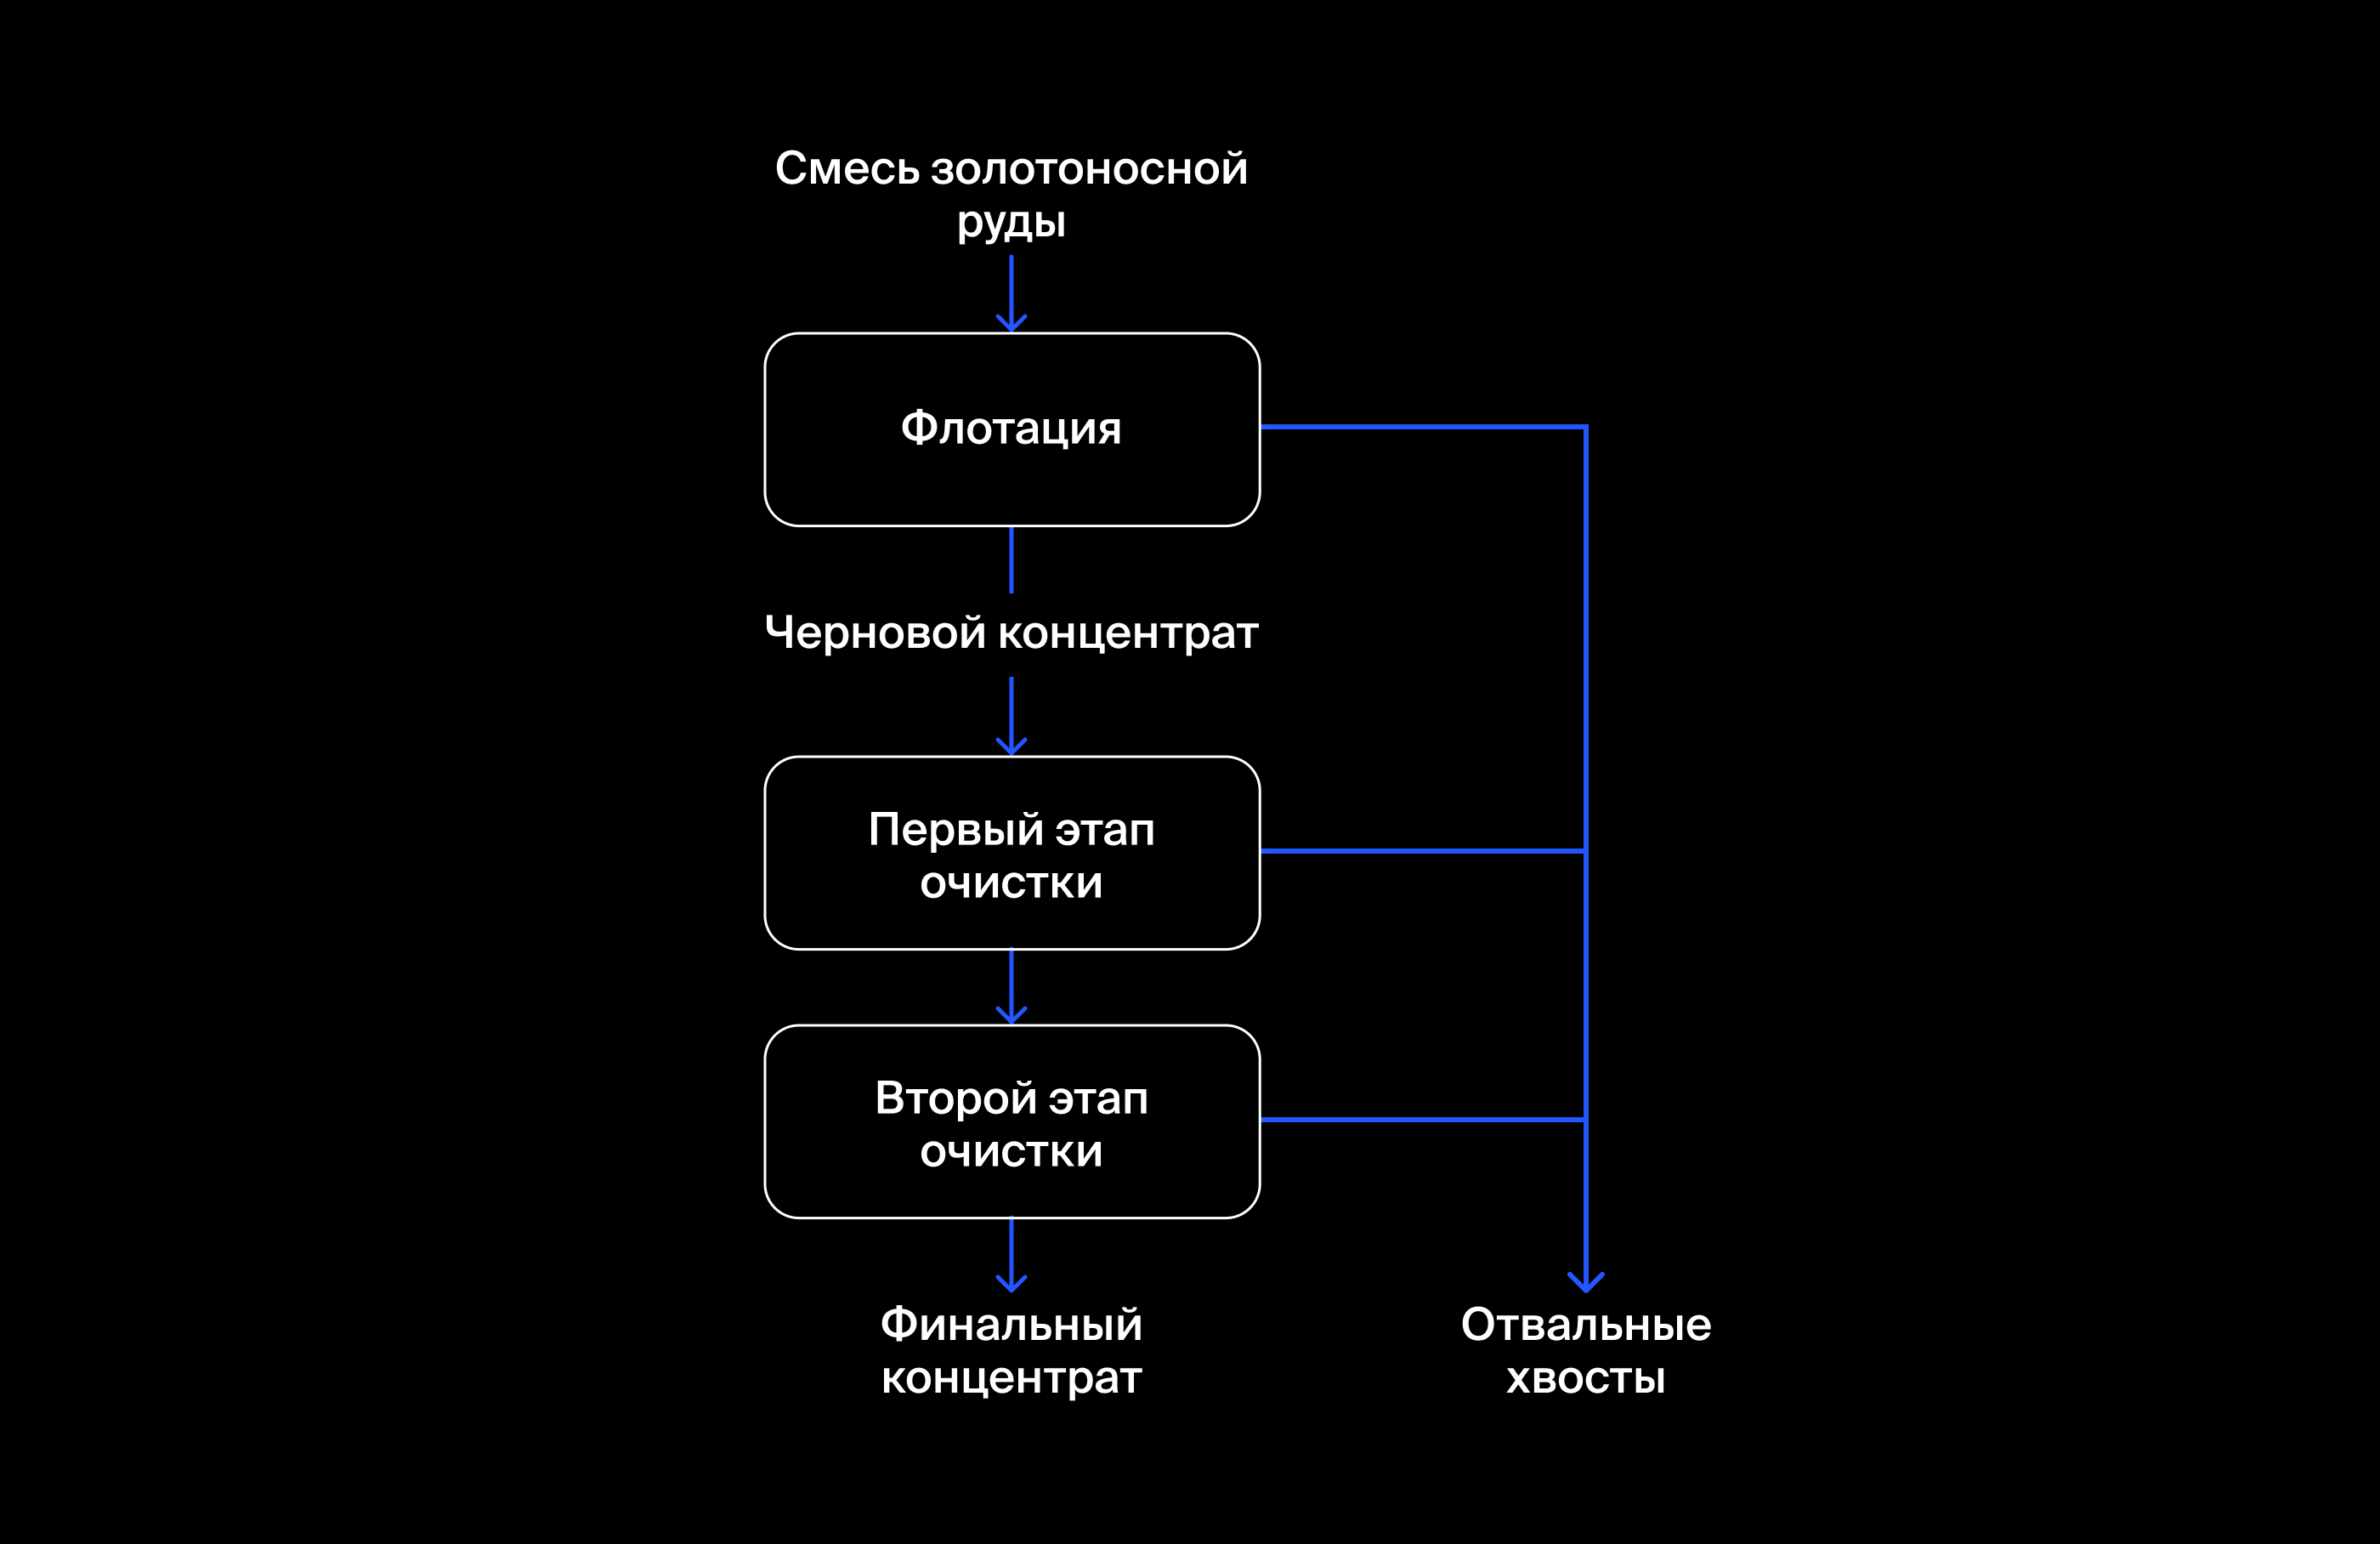

In [ ]:
!pip install catboost -q

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
!python -m pip install prophet -q

In [ ]:
!pip install xgboost -q

In [ ]:
!pip install lightgbm -q

In [ ]:
!pip install optuna -q

     |████████████████████████████████| 308 kB 30.4 MB/s 
     |████████████████████████████████| 209 kB 69.0 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 78 kB 7.2 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
     |████████████████████████████████| 112 kB 61.1 MB/s 
     |████████████████████████████████| 147 kB 75.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from itertools import groupby
import math
from sklearn.model_selection import KFold
from matplotlib.collections import PathCollection  # для отображения легенды
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D # для отображения легенды
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from lightgbm import LGBMRegressor
import lightgbm 
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
import optuna
from optuna.samplers import TPESampler

from matplotlib.ticker import (
    PercentFormatter,
)  # чтоб оси на графике превращать в проценты
from copy import deepcopy
import prophet as fbp
from prophet import Prophet
from prophet.plot import plot_plotly

In [ ]:
# установка параметров системы
pd.options.display.max_columns = 100  # чтоб выводил все столбцы на экран
pd.options.display.float_format = '{:,.2f}'.format # отображение количества знаков после запятой
color1 = '#5EDC91'

In [ ]:
try:
    df_train = pd.read_csv(
        "https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv"
    )  # скачиваем датасет
    df_test = pd.read_csv(
        "https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv"
    )  # скачиваем датасет
    df_full = pd.read_csv(
        "https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv"
    )  # скачиваем датасет
except:
    print("ошибка связи с сетью")
try:
  df_full.shape # проверка на существование датасета
except:
  try:
    df_train = pd.read_csv("/datasets/gold_recovery_train_new.csv")  # если нет интернета
    df_test = pd.read_csv("/datasets/gold_recovery_test_new.csv")  # если нет интернета
    df_full = pd.read_csv("/datasets/gold_recovery_full_new.csv")  # если нет интернета
  except:
    print("ошибка чтения с диска")
    try:
      spreadsheet_id = "1vNt_ALX6oie-cAlzdLOanCoKLJO75YUt-_oPru8_A7U"
      file_name = "https://docs.google.com/spreadsheets/d/{}/export?format=csv".format(
          spreadsheet_id
      )
      r = requests.get(file_name)
      df_full = pd.read_csv(BytesIO(r.content))
      spreadsheet_id = "1WZTD5SXf2M0KTB99EXTZ5ZljhpXmHoYYNRg18wC6zys"
      r = requests.get(file_name)
      df_train = pd.read_csv(BytesIO(r.content))
      spreadsheet_id = "1u0r4BAwrG7LQqnxFy0EtAPTMQAGgGGMowzkJH1pAt9w"
      r = requests.get(file_name)
      df_test = pd.read_csv(BytesIO(r.content))
    except:
      pass

df_test_raw = df_test.copy() # сохраним нетронутые сеты на всякий случай
df_train_raw = df_train.copy() # сохраним нетронутые сеты на всякий случай
df_full_raw = df_full.copy() # сохраним нетронутые сеты на всякий случай

## Подготовка данных

### Первичное ознакомление

Получим общую информацию о таблицах:

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Согласно документации к данным:

    Технологический процесс:

    Rougher feed — исходное сырье
    Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
        Xanthate **— ксантогенат (промотер, или активатор флотации);
        Sulphate — сульфат (на данном производстве сульфид натрия);
        Depressant — депрессант (силикат натрия).
    Rougher process (англ. «грубый процесс») — флотация
    Rougher tails — отвальные хвосты
    Float banks — флотационная установка
    Cleaner process — очистка
    Rougher Au — черновой концентрат золота
    Final Au — финальный концентрат золота

    Параметры этапов:

    air amount — объём воздуха
    fluid levels — уровень жидкости
    feed size — размер гранул сырья
    feed rate — скорость подачи

    Наименование признаков должно быть такое:
    [этап].[тип_параметра].[название_параметра]
    
    Пример: rougher.input.feed_ag
    Возможные значения для блока [этап]:

    rougher — флотация
    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики

    Возможные значения для блока [тип_параметра]:

    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

Пока заметно, что количество столбцов в тестовой выборке, меньше чем в остальных.

Выведем на экран первые пять строк таблиц:

In [ ]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,3

In [ ]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.80,14.99,8.08,1.01,"1,398.98",-500.23,"1,399.14",-499.92,"1,400.10",-500.70,"1,399.00",-499.49,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,"1,001.85",-350.30,"1,249.74",-399.11,"1,249.75",-399.40,"1,198.29",-399.49,999.47,-399.53,949.57,-398.18,24.94,-500.49,14.95,-500.01,20.02,-450.40,13.99,-449.83,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
1,2016-09-01 01:59:59,215.39,14.99,8.08,0.99,"1,398.78",-500.06,"1,398.06",-499.78,"1,396.15",-499.24,"1,399.51",-500.42,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,998.69,-350.43,"1,248.40",-399.95,"1,249.51",-399.63,"1,200.51",-399.94,"1,000.00",-399.49,950.20,-405.79,24.92,-499.81,14.93,-500.76,19.99,-450.11,14.09,-450.06,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2,2016-09-01 02:59:59,215.26,12.88,7.79,1.00,"1,398.49",-500.87,"1,398.86",-499.76,"1,398.08",-502.15,"1,399.50",-499.72,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,998.52,-349.78,"1,247.44",-400.26,"1,248.21",-401.07,"1,199.77",-400.79,999.93,-399.24,950.32,-400.86,24.91,-500.30,15.00,-500.99,20.04,-450.26,14.08,-449.66,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
3,2016-09-01 03:59:59,215.34,12.01,7.64,0.86,"1,399.62",-498.86,"1,397.44",-499.21,"1,400.13",-498.36,"1,401.07",-501.04,12.40,5.11,476.62,59.87,41.06,12.18,16.53,5.80,16.52,5.80,"1,000.28",-350.17,"1,251.32",-398.66,"1,250.49",-399.75,"1,199.40",-397.50,"1,001.93",-400.44,950.74,-399.80,24.89,-499.38,14.92,-499.86,20.03,-449.37,14.01,-449.53,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
4,2016-09-01 04:59:59,199.10,10.68,7.53,0.81,"1,401.27",-500.81,"1,398.13",-499.50,"1,402.17",-500.81,"1,399.48",-499.37,11.33,4.77,488.25,63.32,41.27,11.29,13.61,5.74,13.65,5.74,996.54,-350.56,"1,304.66",-399.51,"1,306.46",-399.05,"1,248.70",-400.88,"1,058.84",-398.99,949.65,-399.28,24.89,-499.36,14.98,-500.19,19.96,-450.64,14.01,-450.02,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86


In [ ]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,"1,549.78",-498.91,"1,551.43",-516.40,"1,549.87",-498.67,"1,554.37",-493.43,"41,885.71","3,481.78","3,520.34",2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,"1,603.01",-434.72,"1,602.38",-442.20,"1,598.94",-451.29,"1,404.47",-455.46,"1,416.35",-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
1,2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,"1,576.17",-500.90,"1,575.95",-499.87,"1,575.99",-499.32,"1,574.48",-498.93,"42,050.86","3,498.37","3,489.98",2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,"1,000.29",-400.07,"1,600.75",-449.95,"1,600.48",-449.83,"1,600.53",-449.95,"1,399.23",-450.87,"1,3

Создадим переменную, где будут храниться все таблицы с данными. И названия таблиц.

In [ ]:
dfs = [df_train,df_test,df_full]
dfs_names = ['тренировочная', 'тестовая', 'полная']

### Изменение типа данных

Чтобы можно было провести дальнейший исследовательский анализ, надо поменять тип данных в столбцах, которые содержат временные данные:

In [ ]:
for x in dfs:
  x["date"] = pd.to_datetime(x["date"], format="%Y-%m-%d %H:%M:%S")  # меняем формат столбца

После того, как мы поменяли тип данных с датой, надо проанализировать эти столбцы:

2016-01-15 00:00:00 2018-08-18 10:59:59


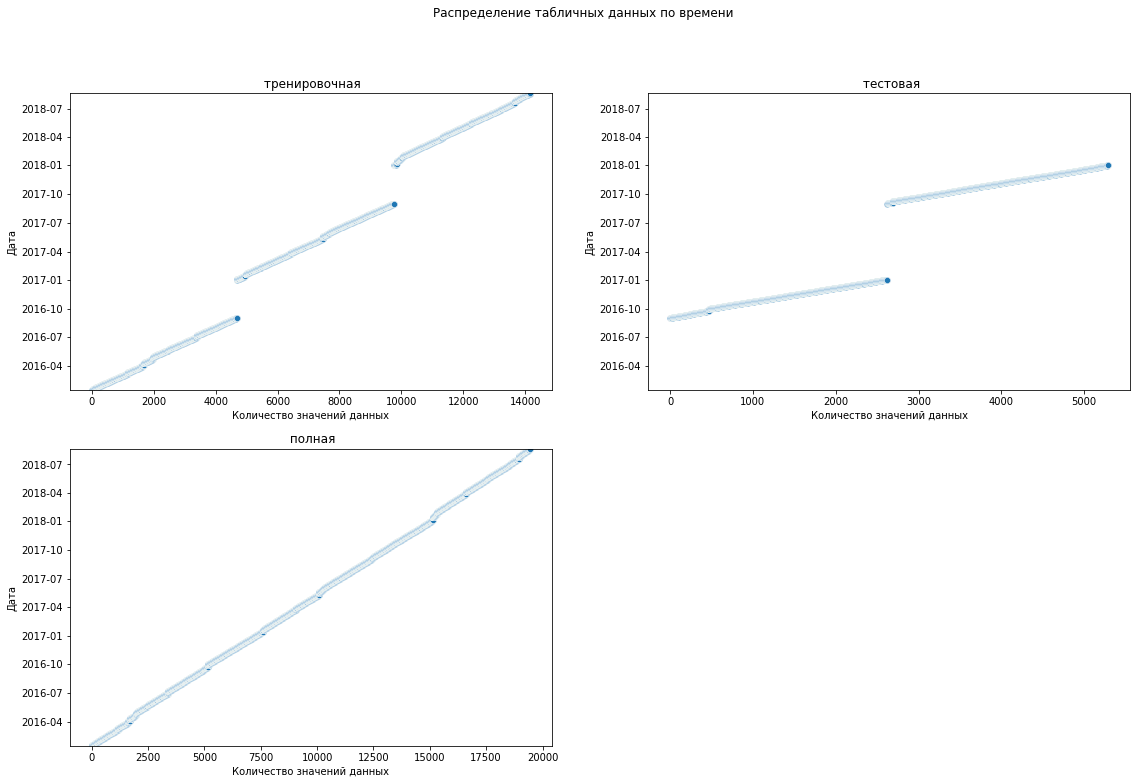

In [ ]:
min = df_full['date'].min()
max = df_full['date'].max()
n= len(dfs)
fig = plt.figure( figsize=(19,12))
fig.suptitle("Распределение табличных данных по времени")
for x in range(len(dfs)):
  axes = fig.add_subplot(2, (np.ceil(n/2)), x+1)
  sns.scatterplot(x=range(len(dfs[x]["date"])), y=dfs[x]["date"].sort_values(), legend=True)
  # axes.set_xticklabels(labels=x_dates)
  axes.set_xlabel("Количество значений данных")
  axes.set_ylim([min, max])
  axes.set_ylabel("Дата")
  axes.set_title(f' {dfs_names[x]}')
print(min, max)

Данные представлены с 2016-01-15  по 2018-08-18

Сделаем индексом дату:

In [ ]:
df_test = df_test.sort_values('date').set_index('date')
df_full = df_full.sort_values('date').set_index('date')
df_train = df_train.sort_values('date').set_index('date')

### Проверка явных дубликатов

In [ ]:
for x in dfs:
  print(x.duplicated().sum())

0
0
0


Явные дубликаты не обнаружены.

### Изучение распределений

Проверим сначала распределение целевых признаков в тренировочной и тестовой выборке:

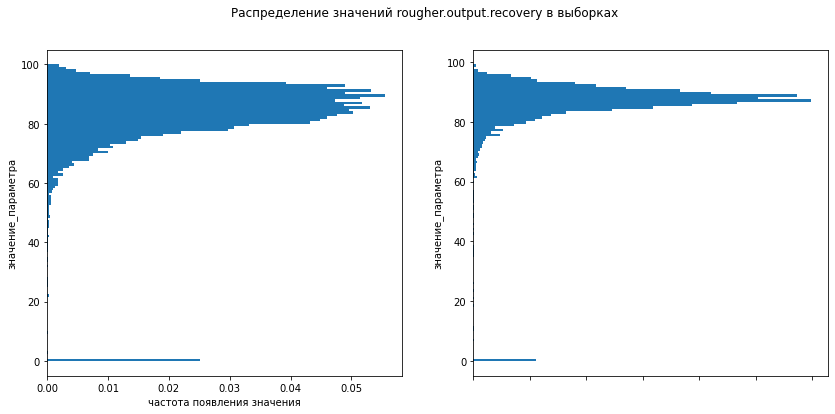

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Распределение значений rougher.output.recovery в выборках")
y = df_train["rougher.output.recovery"]
ax1.set_xlabel("частота появления значения")
ax1.set_ylabel("значение_параметра")
ax2.set_ylabel("значение_параметра")

ax1.hist(y, orientation="horizontal", bins=120,  density = True)
y = df_full.loc[df_test.index, "rougher.output.recovery"]

ax2.hist(y, orientation="horizontal", bins=120,  density = True)
ax2.set_xticklabels([])
plt.show()

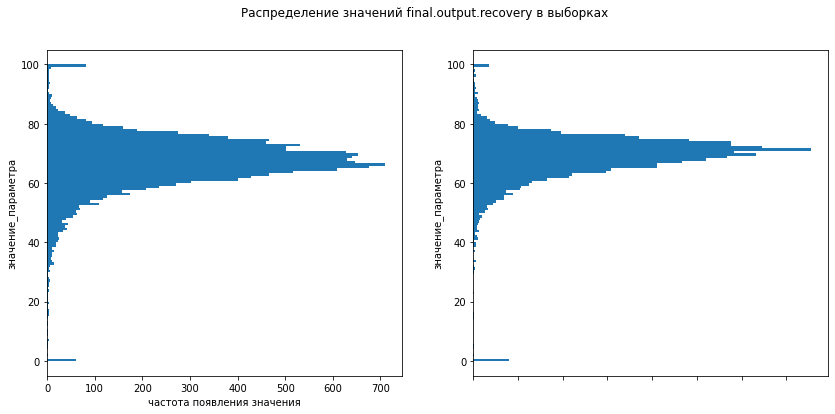

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Распределение значений final.output.recovery в выборках")
y = df_train["final.output.recovery"]
ax1.set_xlabel("частота появления значения")
ax1.set_ylabel("значение_параметра")
ax2.set_ylabel("значение_параметра")

ax1.hist(y, orientation="horizontal", bins=120)
y = df_full.loc[df_test.index, "final.output.recovery"]

ax2.hist(y, orientation="horizontal", bins=120)
ax2.set_xticklabels([])
plt.show()

Распределения похожи.

Проверим распределение самых важных признаков в таблицах:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  # This is added back by InteractiveShellApp.init_path()


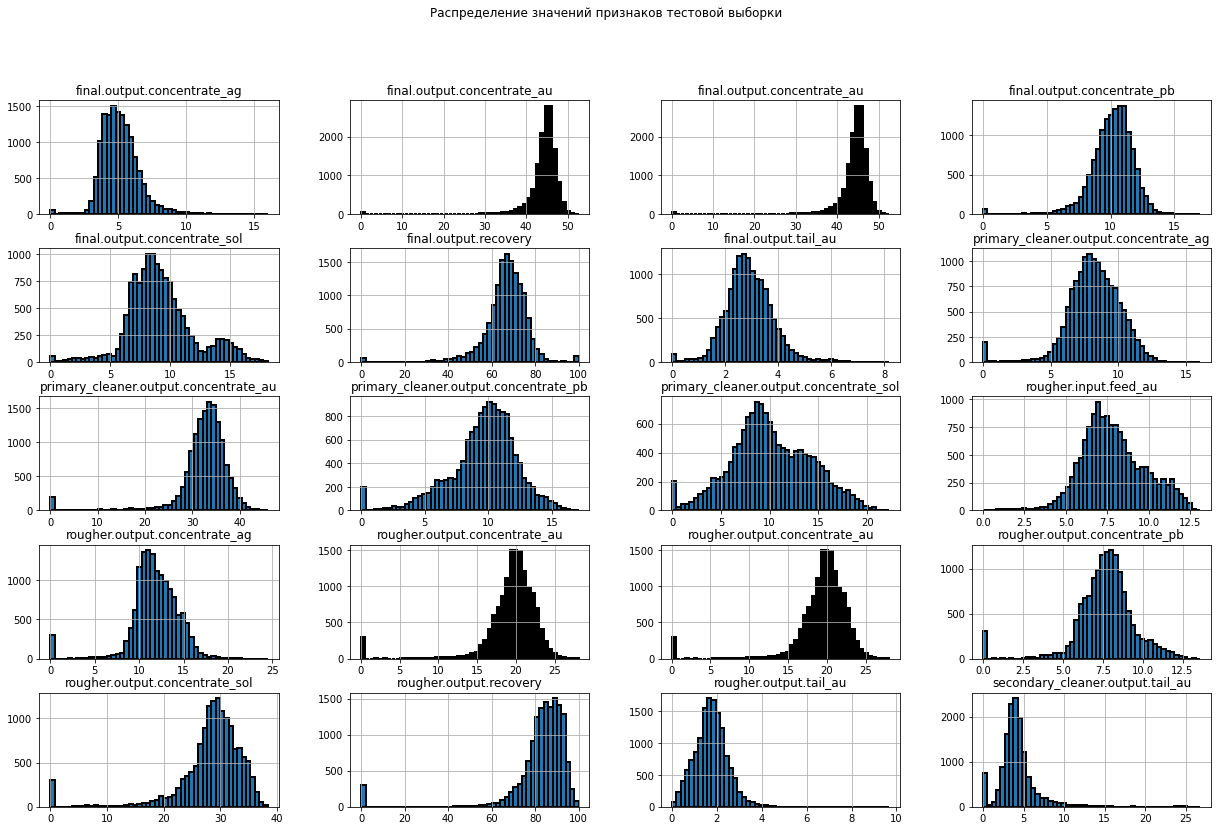

In [ ]:
important_columns = ['rougher.output.concentrate_au','rougher.input.feed_au', 'rougher.output.tail_au',
           'final.output.concentrate_au', 'final.output.tail_au', 'final.output.recovery', 'rougher.output.recovery'] # добавляем признаки которые участвуют в расчетах recovery

columns = important_columns + df_full.columns[df_full.columns.str.contains('concentrate_')].tolist() # добавляем признаки которые связаны с концетратом
columns.append('secondary_cleaner.output.tail_au')
columns = sorted(columns) # сортируем список
important_columns2 = [el for el, _ in groupby(columns)] # убираем повторения в списке

      
fig, ax = plt.subplots(figsize=(21,13))
df_train[columns].hist(    bins=50,  edgecolor="black", linewidth=2, ax=ax)
plt.suptitle("Распределение значений признаков тестовой выборки")
plt.show()

In [ ]:
df_train[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,"14,148.00",5.14,1.37,0.00,4.21,4.99,5.86,16.00
final.output.concentrate_au,"14,149.00",44.00,4.91,0.00,43.28,44.87,46.17,52.76
final.output.concentrate_au,"14,149.00",44.00,4.91,0.00,43.28,44.87,46.17,52.76
final.output.concentrate_pb,"14,148.00",10.13,1.65,0.00,9.30,10.30,11.17,17.03
final.output.concentrate_sol,"13,938.00",9.20,2.79,0.00,7.48,8.85,10.49,18.12
final.output.recovery,"14,149.00",66.52,10.30,0.00,62.55,67.43,72.35,100.00
final.output.tail_au,"14,149.00",2.92,0.90,0.00,2.37,2.85,3.43,8.20
primary_cleaner.output.concentrate_ag,"14,149.00",8.20,2.01,0.00,7.11,8.23,9.50,16.08
primary_cleaner.output.concentrate_au,"14,149.00",32.39,5.80,0.00,30.86,33.23,35.33,45.93
primary_cleaner.output.concentrate_pb,"14,063.00",9.59,2.69,0.00,8.33,9.93,11.31,17.08


Целевые признаки имеют разброс нормальных значений в пределах диапазона (50-95). У некоторых признаков есть выбросы около нулевого значения. 
Также у целевых признаков есть много значений равных 100.
Проверим, не связаны ли показатели целевых признаков за границей нормальных значений с параметром времени:

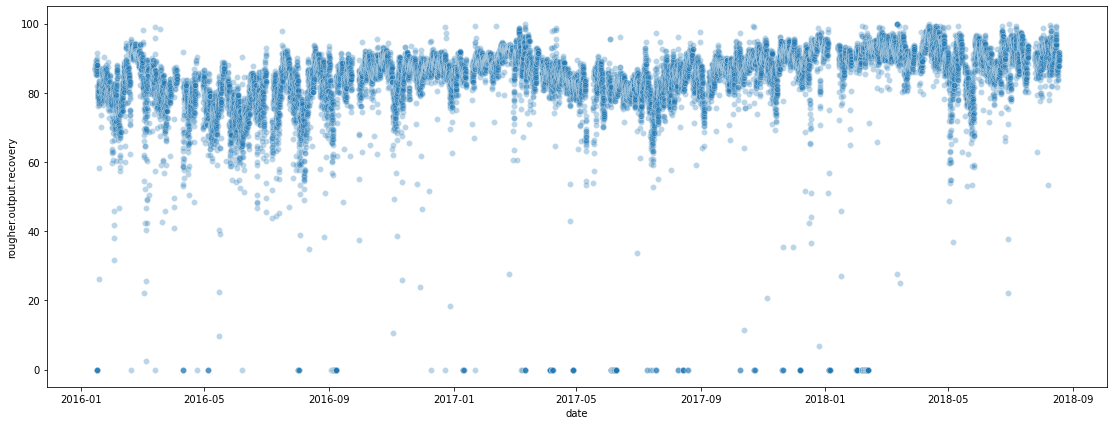

In [ ]:
fig, ax = plt.subplots(figsize=(19,7))
sns.scatterplot(
    x="date",
    y="rougher.output.recovery", data = df_full.sort_values(by='date'), alpha=0.3 )
plt.show()

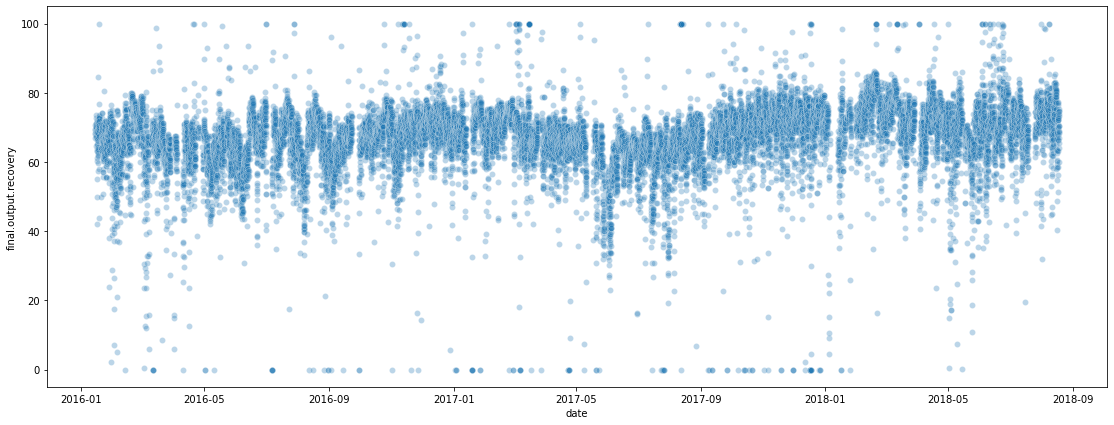

In [ ]:
fig, ax = plt.subplots(figsize=(19,7))
sns.scatterplot(
    x="date",
    y="final.output.recovery", data = df_full.sort_values(by='date'), alpha=0.3 )
plt.show()

Пока не совсем понятна взаимосвязь, но заметно, что некоторые выбросы распределены неравномерно. Изучим целевые признаки в разрезе месяцев:

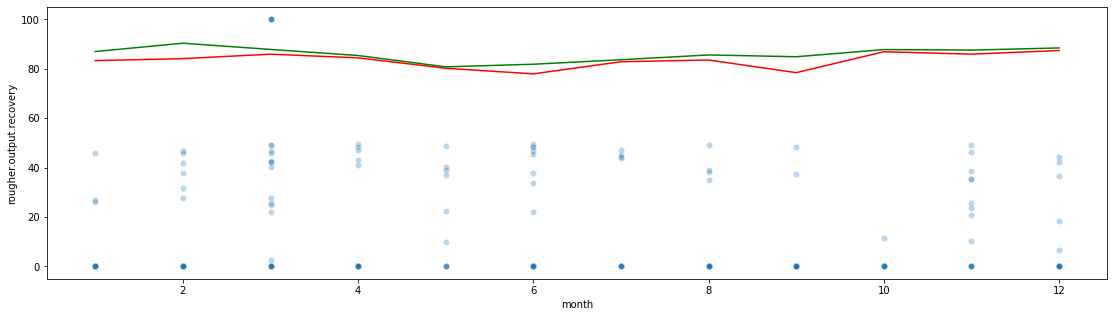

In [ ]:
df_temp = df_full.copy()
df_temp['date'] = df_temp.index
df_temp["month"] = df_temp["date"].dt.month
fig, ax = plt.subplots(figsize=(19,5     ))
sns.scatterplot(
    x="month",
    y="rougher.output.recovery", data = df_temp[(df_temp["rougher.output.recovery"]<50) | (df_temp["rougher.output.recovery"]==100)], alpha=0.3 )
df_temp.groupby("month")['rougher.output.recovery'].mean().plot(c='r')
df_temp.groupby("month")['rougher.output.recovery'].median().plot(c='g')
plt.show()

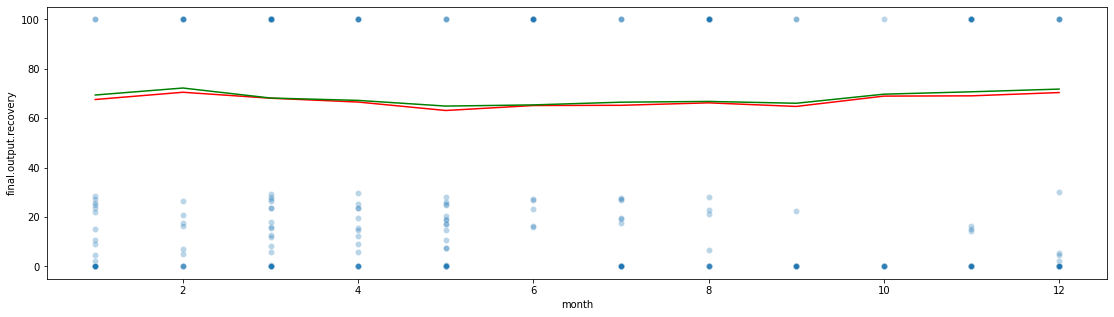

In [ ]:
fig, ax = plt.subplots(figsize=(19,5))
sns.scatterplot(
    x="month",
    y="final.output.recovery", data = df_temp[(df_temp["final.output.recovery"]<30) | (df_temp["final.output.recovery"]==100)], alpha=0.3  )
df_temp.groupby("month")['final.output.recovery'].mean().plot(c='r')
df_temp.groupby("month")['final.output.recovery'].median().plot(c='g')
plt.show()

Ничего нового. А посмотрим по дням:

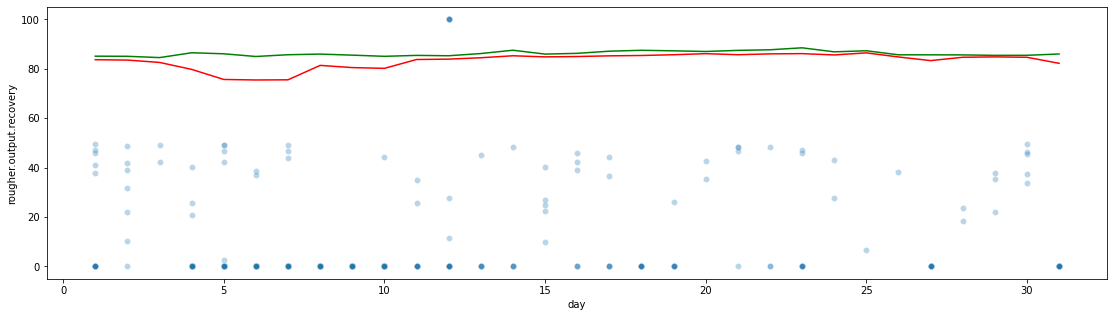

In [ ]:
df_temp["day"] = df_temp["date"].dt.day
fig, ax = plt.subplots(figsize=(19,5))
sns.scatterplot(
    x="day",
    y="rougher.output.recovery", data = df_temp[(df_temp["rougher.output.recovery"]<50) | (df_temp["rougher.output.recovery"]==100)], alpha=0.3  )
df_temp.groupby("day")['rougher.output.recovery'].mean().plot(c='r')
df_temp.groupby("day")['rougher.output.recovery'].median().plot(c='g')
plt.show()

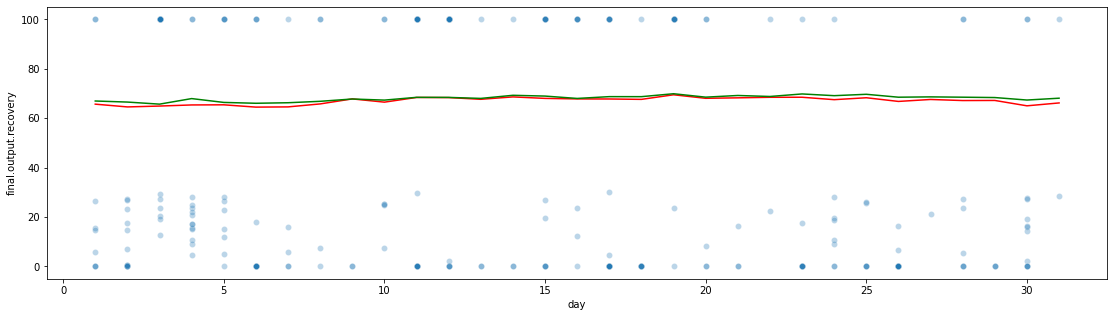

In [ ]:
fig, ax = plt.subplots(figsize=(19,5))
sns.scatterplot(
    x="day",
    y="final.output.recovery", data = df_temp[(df_temp["final.output.recovery"]<30  ) | (df_temp["final.output.recovery"]==100)], alpha=0.3  )
df_temp.groupby("day")['final.output.recovery'].mean().plot(c='r')
df_temp.groupby("day")['final.output.recovery'].median().plot(c='g')
plt.show()

Копаем дальше. Теперь по часам:

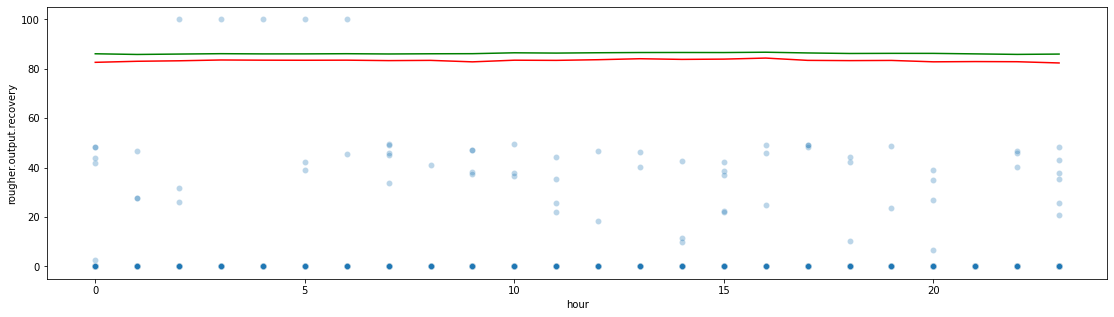

In [ ]:
df_temp["hour"] = df_temp["date"].dt.hour
fig, ax = plt.subplots(figsize=(19,5))
sns.scatterplot(
    x="hour",
    y="rougher.output.recovery", data = df_temp[(df_temp["rougher.output.recovery"]<50) | (df_temp["rougher.output.recovery"]==100)], alpha=0.3  )
df_temp.groupby("hour")['rougher.output.recovery'].mean().plot(c='r')
df_temp.groupby("hour")['rougher.output.recovery'].median().plot(c='g')
plt.show()

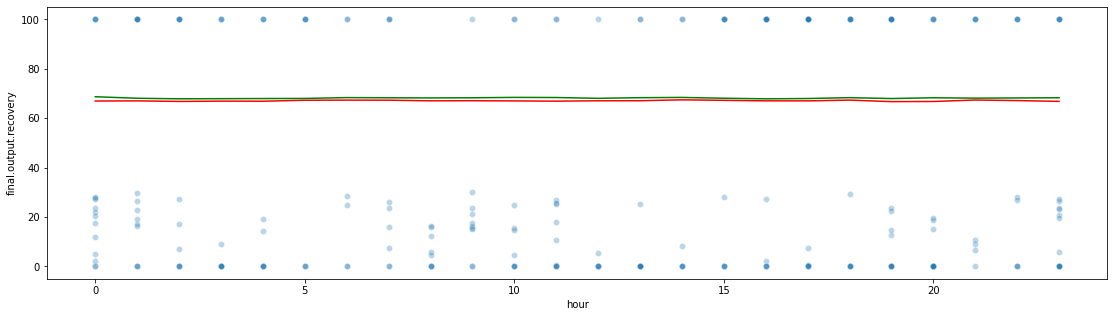

In [ ]:
fig, ax = plt.subplots(figsize=(19,5))
sns.scatterplot(
    x="hour",
    y="final.output.recovery", data = df_temp[(df_temp["final.output.recovery"]<30  ) | (df_temp["final.output.recovery"]==100)], alpha=0.3  )
df_temp.groupby("hour")['final.output.recovery'].mean().plot(c='r')
df_temp.groupby("hour")['final.output.recovery'].median().plot(c='g')
plt.show()

И по дням недели:

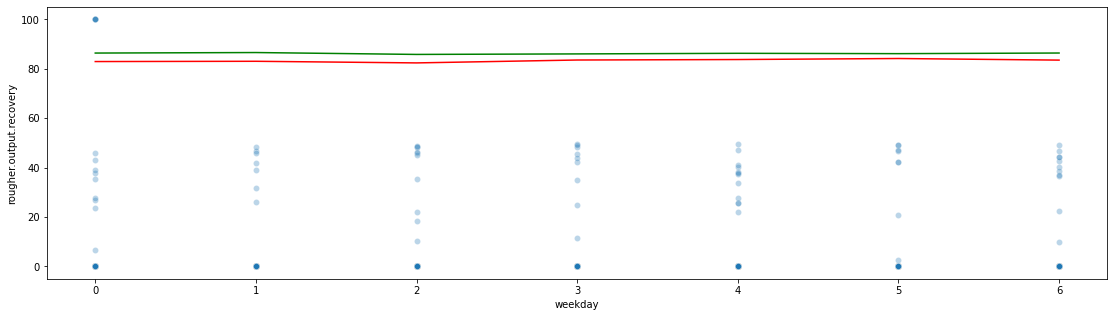

In [ ]:
df_temp["weekday"] = df_temp["date"].dt.weekday
fig, ax = plt.subplots(figsize=(19,5))
sns.scatterplot(
    x="weekday",
    y="rougher.output.recovery", data = df_temp[(df_temp["rougher.output.recovery"]<50) | (df_temp["rougher.output.recovery"]==100)], alpha=0.3  )
df_temp.groupby("weekday")['rougher.output.recovery'].mean().plot(c='r')
df_temp.groupby("weekday")['rougher.output.recovery'].median().plot(c='g')
plt.show()

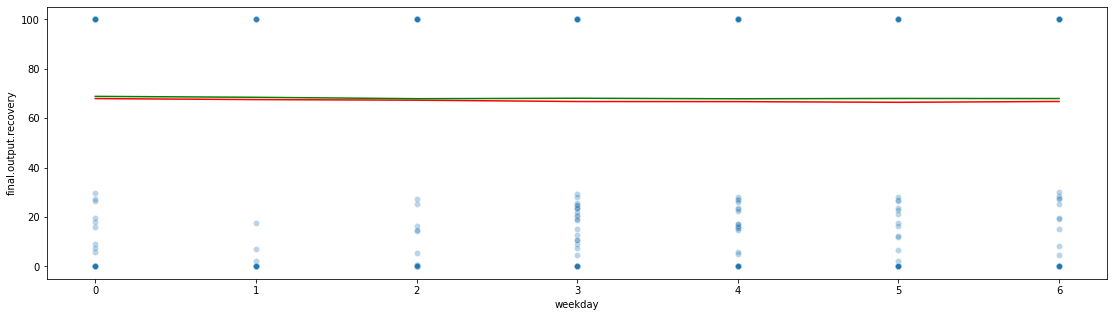

In [ ]:
fig, ax = plt.subplots(figsize=(19,5))
sns.scatterplot(
    x="weekday",
    y="final.output.recovery", data = df_temp[(df_temp["final.output.recovery"]<30  ) | (df_temp["final.output.recovery"]==100)], alpha=0.3  )
df_temp.groupby("weekday")['final.output.recovery'].mean().plot(c='r')
df_temp.groupby("weekday")['final.output.recovery'].median().plot(c='g')
plt.show()

Интересных замечаний не выявлено.
Кроме того, что наиболее явные отклонения значений целевых признаков проявляются на определенных временных участках. Посмотрим что происходит на одном таком временном участке:

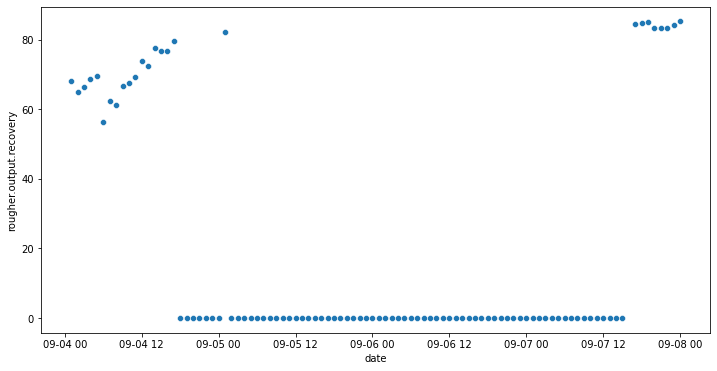

In [ ]:
g = 'rougher.output.recovery'
df_temp['day_date'] =df_temp.index.to_numpy().astype('datetime64[D]')
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(
    x=df_temp.loc[(df_temp['day_date']>='2016-09-04')&(df_temp['day_date']<'2016-09-08')].index,
    y=df_temp.loc[(df_temp['day_date']>='2016-09-04')&(df_temp['day_date']<'2016-09-08')][g])
plt.show()

Заметно, что несколько дней подряд, целевой показатель не показывал ничего кроме нуля. Вероятно, сбой аппаратуры. Примем это к сведению. <a id='malf'></a>    

Удалим выбросы, чтобы проанализовать лучше распределения:

In [ ]:
df_temp = df_full.copy()
df_temp.loc[:,'rougher.output.recovery'] = df_temp.loc[:,'rougher.output.recovery'].replace(100, np.nan)
df_temp.loc[:,'final.output.recovery'] = df_temp.loc[:, 'final.output.recovery'].replace(100, np.nan)
columns =[]
columns = df_full.columns[df_full.columns.str.contains('.concentrate_')].tolist() # возьмем все признаки кроме тех, что имеют отрицательные значения
columns = important_columns2 + columns
columns = sorted(columns) # сортируем список
columns = [el for el, _ in groupby(columns)] # убираем повторения в списке

for i in columns:  # удаляем значения, которые близки к нулю
  df_temp[i] = df_temp[i].where(df_temp[i]>0.01, np.nan)

df_clean = df_temp.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


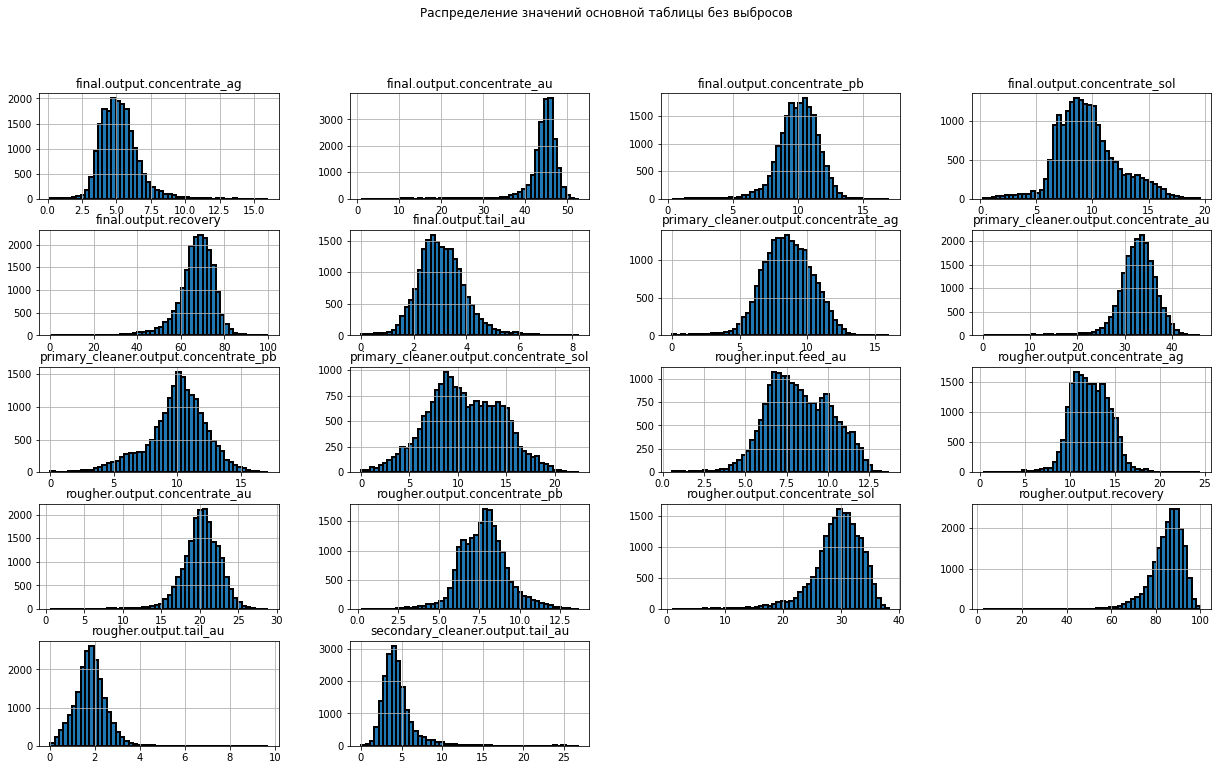

In [ ]:
fig, ax = plt.subplots(figsize=(21,12))
df_clean[important_columns2].hist(    bins=50,  edgecolor="black", linewidth=2, ax=ax)
plt.suptitle("Распределение значений основной таблицы без выбросов")
plt.show()

In [ ]:
target_columns = ['rougher.output.recovery', 'final.output.recovery']

Теперь распределения значений выглядят очень сбалансированными. Но мы не можем удалять значения выбросов в целевом признаке тестовой выборки (по условию задачи), поэтому оставим экстремальные значения в тренировочной, полной и тестовой выборке как есть, чтобы приблизить условия к "боевым".

### Проверка пропусков

Посмотрим, какие и сколько пропусков в данных:

In [ ]:
for x in range(3):
  print(dfs_names[x])
  print(dfs[x].isna().sum()[dfs[x].isna().sum()>1].sort_values(ascending=False))
  print()

тренировочная
secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
final.output.tail_pb                         100
primary_cleaner.output.concentrate_pb         86
rougher.input.feed_sol                        78
primary_cleaner.output.tail_sol               46
rougher.input.floatbank11_sulfate             36
primary_cleaner.input.depressant              32
rougher.input.floatbank10_sulfate             29
rougher.output.concentrate_sol                22
secondary_cleaner.state.floatbank2_b_air      21
primary_cleaner.input.sulfate                 20
primary_cleaner.output.tail_pb                15
second

Данные имеют пропуски. Заполним их средним на основе соседних значений на этапе формирования выборок для моделей.
Такой способ был выбран исходя из информации, что соседние по времени параметры часто похожи. 
Отдельно проверим пропуски целевых признаков в таблицах:

In [ ]:
df_train[important_columns].isna().sum().sort_values(ascending=False)

rougher.output.concentrate_au    0
rougher.input.feed_au            0
rougher.output.tail_au           0
final.output.concentrate_au      0
final.output.tail_au             0
final.output.recovery            0
rougher.output.recovery          0
dtype: int64

In [ ]:
df_full[important_columns].isna().sum().sort_values(ascending=False)

rougher.output.concentrate_au    0
rougher.input.feed_au            0
rougher.output.tail_au           0
final.output.concentrate_au      0
final.output.tail_au             0
final.output.recovery            0
rougher.output.recovery          0
dtype: int64

Проверка, после всех наших манипуляций с данными:

In [ ]:
t = round((len(df_test_raw) - len(df_test))*100/len(df_test_raw),1)
print(f'Удалили {t} % данных  из тестовой выборки')

Удалили 0.0 % данных  из тестовой выборки


In [ ]:
t = round((len(df_train_raw) - len(df_train))*100/len(df_train_raw),1)
print(f'Удалили {t} % данных  из тренировочной выборки')

Удалили 0.0 % данных  из тренировочной выборки


### Проверка эффективности обогащения на этапе флотации

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery` и сравним с тем, что есть в таблице.

Согласно имеющимся данным:

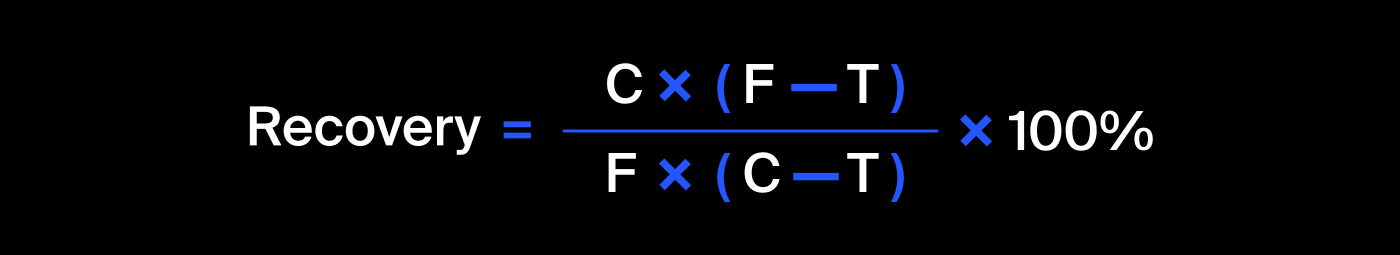

где:

    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.

Посчитаем `rougher.output.recovery` самостоятельно:

In [ ]:
c = df_train['rougher.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['rougher.output.tail_au']

In [ ]:
df_temp = pd.DataFrame() # создадим временный датафрейм
df_temp['rougher.output.concentrate_au'] = c
df_temp['rougher.input.feed_au'] = f
df_temp['rougher.output.tail_au'] = t
df_temp['rougher.output.recovery'] = df_train['rougher.output.recovery']

In [ ]:
df_temp['test_recovery'] = (c*(f-t))/(f*(c-t))*100
df_temp = df_temp.dropna(axis=0)

In [ ]:
df_temp.head()

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,test_recovery
date,,,,,
2016-01-15 00:00:00,19.79,6.49,1.17,87.11,87.11
2016-01-15 01:00:00,20.05,6.48,1.18,86.84,86.84
2016-01-15 02:00:00,19.74,6.36,1.16,86.84,86.84
2016-01-15 03:00:00,19.32,6.12,1.08,87.23,87.23
2016-01-15 04:00:00,19.22,5.66,1.01,86.69,86.69


Найдем MAE между нашими расчётами и значением признака.

In [ ]:
mae = mean_absolute_error(df_temp['rougher.output.recovery'], df_temp['test_recovery'])
print('Средняя абсолютная ошибка:', mae)

Средняя абсолютная ошибка: 9.73512347450521e-15


Ошибка близка к нулю. Значения признака расчитаны верно.

Проверим заодно и расчеты `final.output.recovery`

In [ ]:
c = df_train['final.output.concentrate_au']
f = df_train['rougher.input.feed_au']
t = df_train['final.output.tail_au']

In [ ]:
df_temp = pd.DataFrame() # создадим временный датафрейм
df_temp['final.output.concentrate_au'] = c
df_temp['rougher.input.feed_au'] = f
df_temp['final.output.tail_au'] = t
df_temp['final.output.recovery'] = df_train['final.output.recovery']

In [ ]:
df_temp['test_recovery'] = (c*(f-t))/(f*(c-t))*100
df_temp = df_temp.dropna(axis=0)

In [ ]:
df_temp.head()

,final.output.concentrate_au,rougher.input.feed_au,final.output.tail_au,final.output.recovery,test_recovery
date,,,,,
2016-01-15 00:00:00,42.19,6.49,2.14,70.54,70.54
2016-01-15 01:00:00,42.70,6.48,2.22,69.27,69.27
2016-01-15 02:00:00,42.66,6.36,2.26,68.12,68.12
2016-01-15 03:00:00,42.69,6.12,2.15,68.35,68.35
2016-01-15 04:00:00,42.77,5.66,2.06,66.93,66.93


Найдем MAE между нашими расчётами и значением признака.

In [ ]:
mae = mean_absolute_error(df_temp['final.output.recovery'], df_temp['test_recovery'])
print('Средняя абсолютная ошибка:', mae)

Средняя абсолютная ошибка: 8.538049763979541e-15


Аналогично. Расчеты сделаны верно.

### Анализ признаков, недоступных в тестовой выборке

Тестовая выборка содержит меньше признаков, чем остальные таблицы. Посмотрим какие столбцы отсутствуют:

In [ ]:
columns = set(df_train.columns) - set(df_test.columns)
columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Заметно, что отсутствуют признаки из блоков `output` - параметры продуктов, `calculation` - расчётные характеристики.
Также отсутствуют целевые признаки.

Утечки финального целевого признака `final.output.recovery` не будет.
А чтобы предотвратить утечку `rougher.output.recovery` потребуется удалить все признаки, которые получаются во после флотации. Сделаем это на этапе формирования выборок для моделей.


_____________

Проверим, есть ли где различия между тестовой выборкой и основной таблицей:

In [ ]:
df_test.eq(df_full.loc[df_test.index, df_test.columns]).isna().sum().sum()

0

Проверим, есть ли где различия между тренировочной выборкой и основной таблицей:

In [ ]:
df_train.eq(df_full.loc[df_train.index, df_test.columns]).isna().sum().sum()

0

Различий в данных нет. 

## Исследовательский анализ данных

### Изучение концентрации металлов

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

**Изменение концентрации золота**

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_clean[df_full.columns[df_full.columns.str.contains('au', regex=False)].tolist()].copy() # забираем столбцы связанные с золотом

In [ ]:
df_temp.columns

Index(['final.output.concentrate_au', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au',
       'rougher.output.concentrate_au', 'rougher.output.tail_au',
       'secondary_cleaner.output.tail_au'],
      dtype='object')

In [ ]:
df_temp = df_temp[['rougher.input.feed_au','rougher.output.concentrate_au', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.tail_au','secondary_cleaner.output.tail_au', 'final.output.concentrate_au','final.output.tail_au']]

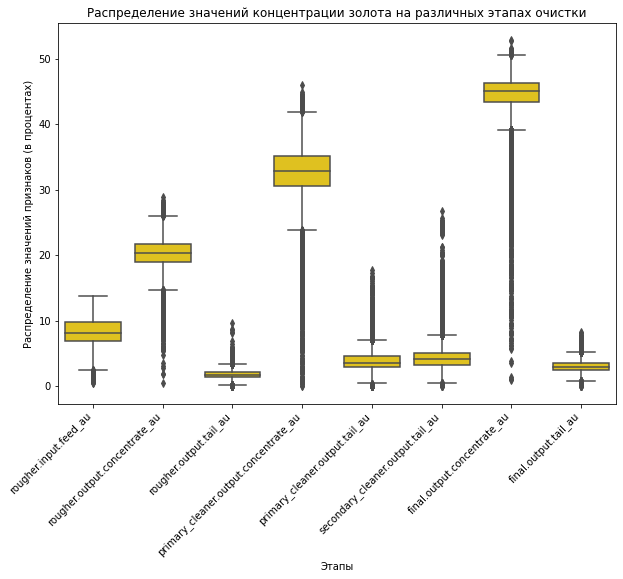

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(
     data=df_temp, color='gold'
)
plt.ylabel("Распределение значений признаков (в процентах)")
plt.title("Распределение значений концентрации золота на различных этапах очистки")
ax.set_xlabel("Этапы")
plt.xticks(rotation=45, ha='right')
plt.show()

Заметно, что концентрация содержания золота повышается по мере очистки и достигает своих максимума в конце технологического процесса. 

**Изменение концентрации серебра**

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_clean[df_full.columns[df_full.columns.str.contains('ag', regex=False)].tolist()].copy()

In [ ]:
df_temp.columns

Index(['final.output.concentrate_ag', 'final.output.tail_ag',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.tail_ag', 'rougher.input.feed_ag',
       'rougher.output.concentrate_ag', 'rougher.output.tail_ag',
       'secondary_cleaner.output.tail_ag'],
      dtype='object')

In [ ]:
df_temp = df_temp[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'rougher.output.tail_ag','primary_cleaner.output.concentrate_ag','primary_cleaner.output.tail_ag','secondary_cleaner.output.tail_ag', 'final.output.concentrate_ag', 'final.output.tail_ag']]

In [ ]:
df_temp.dtypes

rougher.input.feed_ag                    float64
rougher.output.concentrate_ag            float64
rougher.output.tail_ag                   float64
primary_cleaner.output.concentrate_ag    float64
primary_cleaner.output.tail_ag           float64
secondary_cleaner.output.tail_ag         float64
final.output.concentrate_ag              float64
final.output.tail_ag                     float64
dtype: object

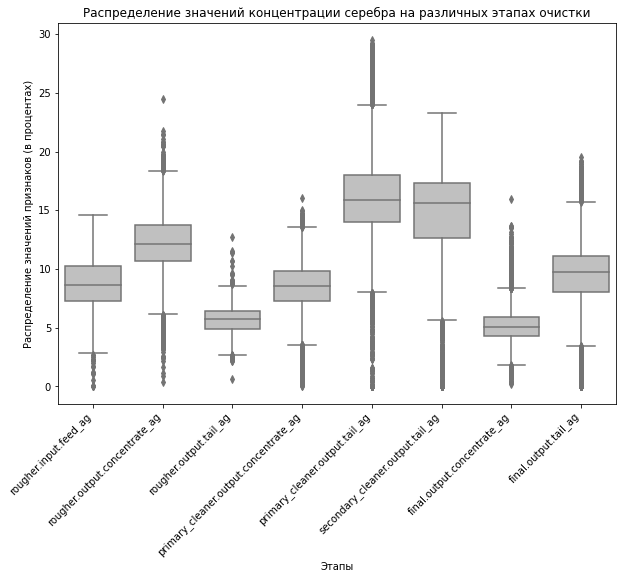

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=df_temp, color='silver')
plt.ylabel("Распределение значений признаков (в процентах)")
plt.title("Распределение значений концентрации серебра на различных этапах очистки")
ax.set_xlabel("Этапы")
plt.xticks(rotation=45, ha='right')
plt.show()

Заметно, что концентрация содержания серебра повышается по завершению этапа флотации и по мере очистки начинает снижаться.
Причем максимума доля серебра достигает в отвальных хвостах после первичной очистки.


**Изменение концентрации свинца**

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_clean[df_full.columns[df_full.columns.str.contains('pb', regex=False)].tolist()].copy()

In [ ]:
df_temp.columns

Index(['final.output.concentrate_pb', 'final.output.tail_pb',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.tail_pb', 'rougher.calculation.au_pb_ratio',
       'rougher.input.feed_pb', 'rougher.output.concentrate_pb',
       'rougher.output.tail_pb', 'secondary_cleaner.output.tail_pb'],
      dtype='object')

In [ ]:
df_temp = df_temp[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'rougher.output.tail_pb','primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.tail_pb','secondary_cleaner.output.tail_pb', 'final.output.concentrate_pb', 'final.output.tail_pb']]

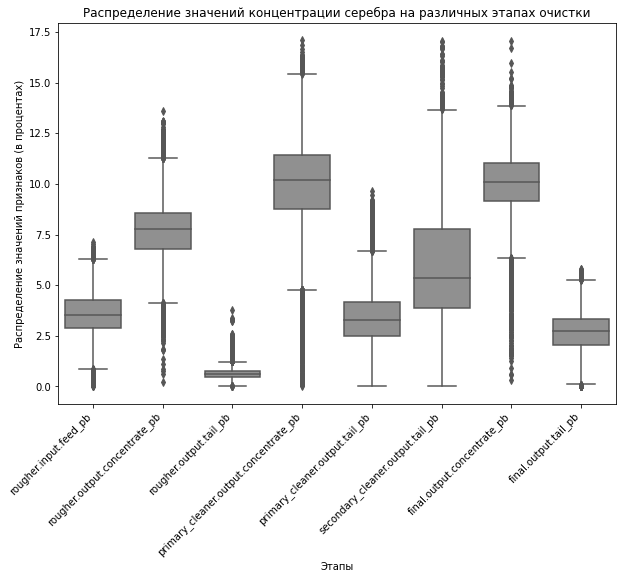

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(
     data=df_temp, color='#909090'
)
plt.ylabel("Распределение значений признаков (в процентах)")
plt.title("Распределение значений концентрации серебра на различных этапах очистки")
ax.set_xlabel("Этапы")
plt.xticks(rotation=45, ha='right')
plt.show()

Мы видим, что содержание свинца начинает подниматься по завершению этапа флотации и сохраняется либо незначительно увеличивается на этапах очистки. В финальном концетрате доля свинца примерно такая же как после первого этапа очистки.


### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. 

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках перед флотацией:

In [ ]:
df_temp = pd.DataFrame()
df_temp['train'] = df_train['rougher.input.feed_size'].reset_index(drop=True)
df_temp['test'] = df_test['rougher.input.feed_size'].reset_index(drop=True)

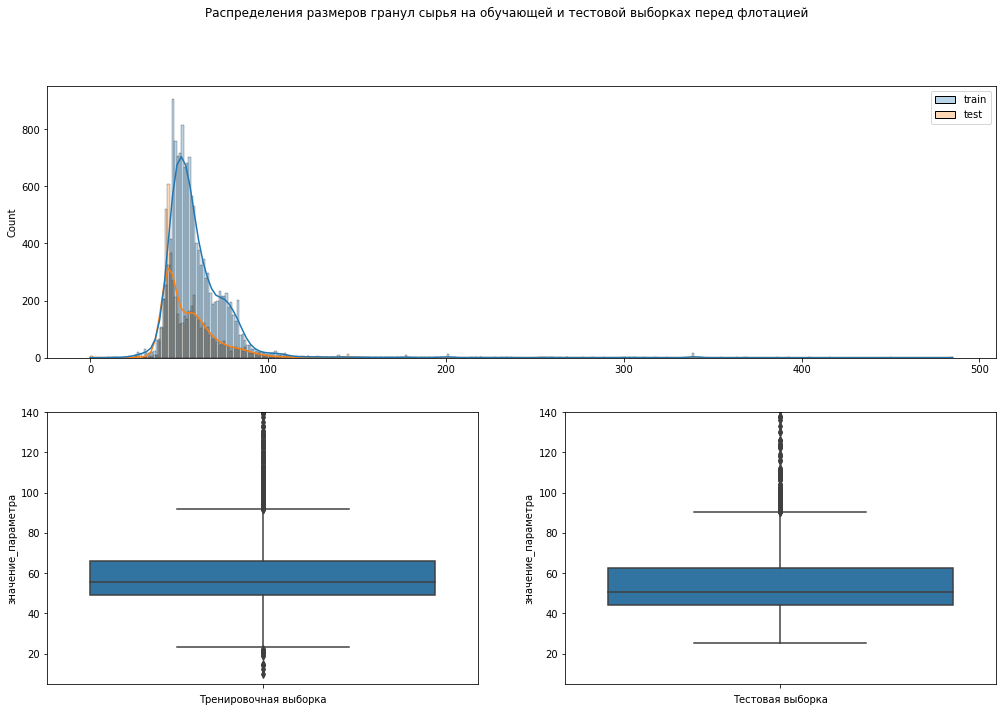

In [ ]:
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
fig = plt.figure(figsize=(17, 11), constrained_layout=False)
ax1 = plt.subplot(gs[0, :], )
ax2 = plt.subplot(gs[1, :2])
ax3 = plt.subplot(gs[1, 2:])

fig.suptitle("Распределения размеров гранул сырья на обучающей и тестовой выборках перед флотацией")

sns.histplot(data = df_temp, color='blue', kde=True, alpha = .3, ax=ax1)
ax2.set_xlabel("Тренировочная выборка")
ax3.set_xlabel("Тестовая выборка")
ax2.set_ylabel("значение_параметра")
ax3.set_ylabel("значение_параметра")
sns.boxplot(data=df_temp["train"], orient="v", ax=ax2)
sns.boxplot(data=df_temp["test"], orient="v", ax=ax3)
ax2.set_ylim([5, 140])
ax3.set_ylim([5, 140])
ax3.set_xticklabels([])
ax2.set_xticklabels([])

plt.show()

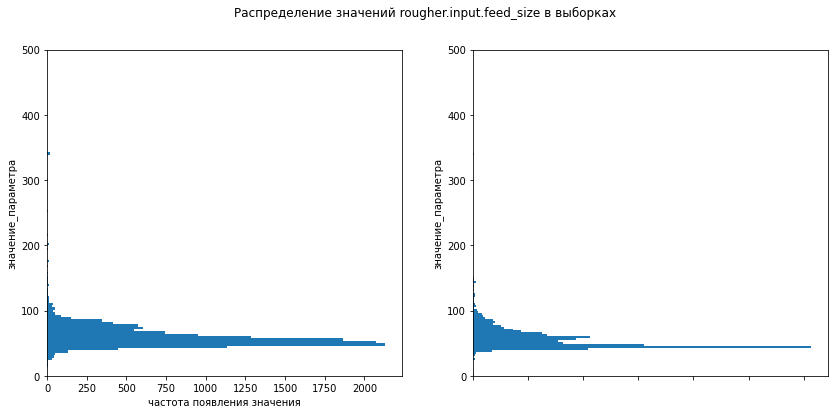

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Распределение значений rougher.input.feed_size в выборках")
y = df_temp["train"]
ax1.set_xlabel("частота появления значения")
ax1.set_ylabel("значение_параметра")
ax2.set_ylabel("значение_параметра")
ax1.set_ylim([0, 500])
ax2.set_ylim([0, 500])
ax1.hist(y, orientation="horizontal", bins=130)
y = df_temp["test"]

ax2.hist(y, orientation="horizontal", bins=130)
ax2.set_xticklabels([])
plt.show()

In [ ]:
df_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
train,"14,005.00",60.11,22.42,9.66,48.97,55.37,66.08,484.97
test,"5,289.00",55.95,19.08,0.05,43.91,50.84,62.43,392.49


Выборки отличаются по небольшим выбросам с обоих сторон, но средние и медианы близки к друг другу, так же как и ядро распределений.

### Суммарная концентрация веществ на разных стадиях производства

Исследуем суммарную концентрацию всех веществ (свинца, серебра, золота) на всех  доступных стадиях: в сырье, в черновом, после первой очистки и в финальном концентрате. Для этого выделим необходимые столбцы из полной таблицы:

In [ ]:
df_temp = pd.DataFrame()
df_temp = df_clean.copy()
crude = 'rougher.input.feed_'
crude_out = 'rougher.output.concentrate_'
prim_clean = 'primary_cleaner.output.concentrate_'
final = 'final.output.concentrate_'

df_temp['сырье'] = df_temp[[crude+'au', crude+'ag', crude+'pb']].sum(axis=1)
df_temp['черновой концентрат'] = df_temp[[crude_out+'au', crude_out+'ag', crude_out+'pb']].sum(axis=1)
df_temp['концентрат после 1ой очистки'] = df_temp[[prim_clean+'au', prim_clean+'ag', prim_clean+'pb']].sum(axis=1)
df_temp['финальный концентрат'] = df_temp[[final+'au', final+'ag', final+'pb']].sum(axis=1)
df_temp = df_temp[['сырье', 'черновой концентрат', 'концентрат после 1ой очистки', 'финальный концентрат']]

In [ ]:
df_temp.head()

,сырье,черновой концентрат,концентрат после 1ой очистки,финальный концентрат
date,,,,
2016-01-15 00:00:00,14.87,38.40,53.11,58.14
2016-01-15 01:00:00,14.91,38.95,53.17,58.70
2016-01-15 02:00:00,14.64,38.65,52.93,58.93
2016-01-15 03:00:00,14.20,38.41,43.98,58.71
2016-01-15 04:00:00,13.51,38.87,52.12,59.07


In [ ]:
df_temp[df_temp['концентрат после 1ой очистки']<1]

,сырье,черновой концентрат,концентрат после 1ой очистки,финальный концентрат
date,,,,
2016-01-15 19:00:00,15.62,36.84,0.00,58.60
2016-01-15 22:00:00,14.74,36.31,0.00,58.01
2016-01-16 06:00:00,14.72,36.54,0.00,58.96
2016-01-18 01:00:00,16.99,36.22,0.00,61.12
2016-01-18 04:00:00,17.60,36.28,0.00,58.32
...,...,...,...,...
2018-08-10 03:59:59,28.43,43.60,0.00,60.02
2018-08-10 04:59:59,28.33,44.06,0.00,59.52
2018-08-10 05:59:59,27.94,43.44,0.00,59.34


In [ ]:
df_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
сырье,"19,439.00",20.64,4.49,0.02,17.25,20.14,23.80,33.50
черновой концентрат,"19,439.00",39.37,6.86,0.00,38.39,40.31,42.37,55.57
концентрат после 1ой очистки,"19,439.00",50.33,7.67,0.00,50.04,51.91,53.39,60.27
финальный концентрат,"19,439.00",59.22,6.10,0.00,59.30,60.31,61.10,64.97


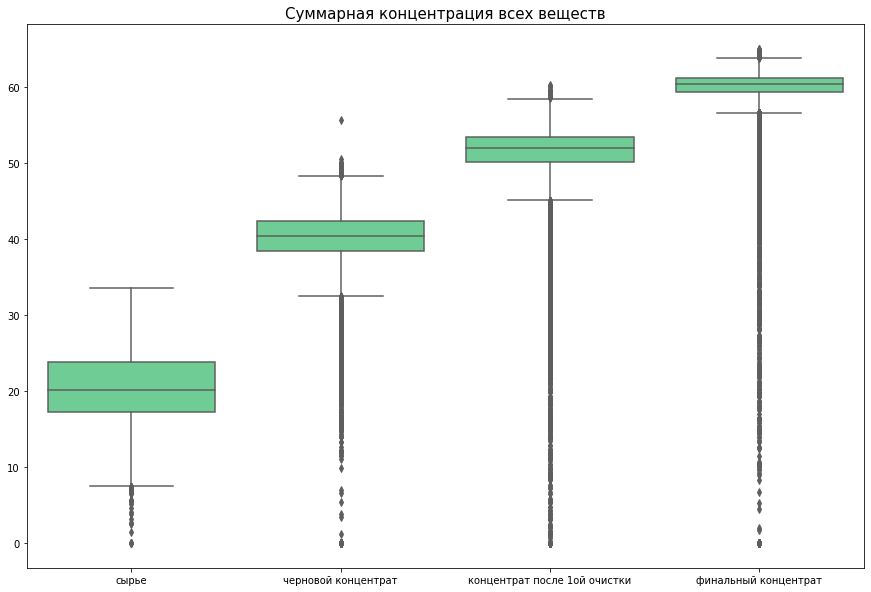

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data=df_temp, color=color1 )
plt.title('Суммарная концентрация всех веществ', fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


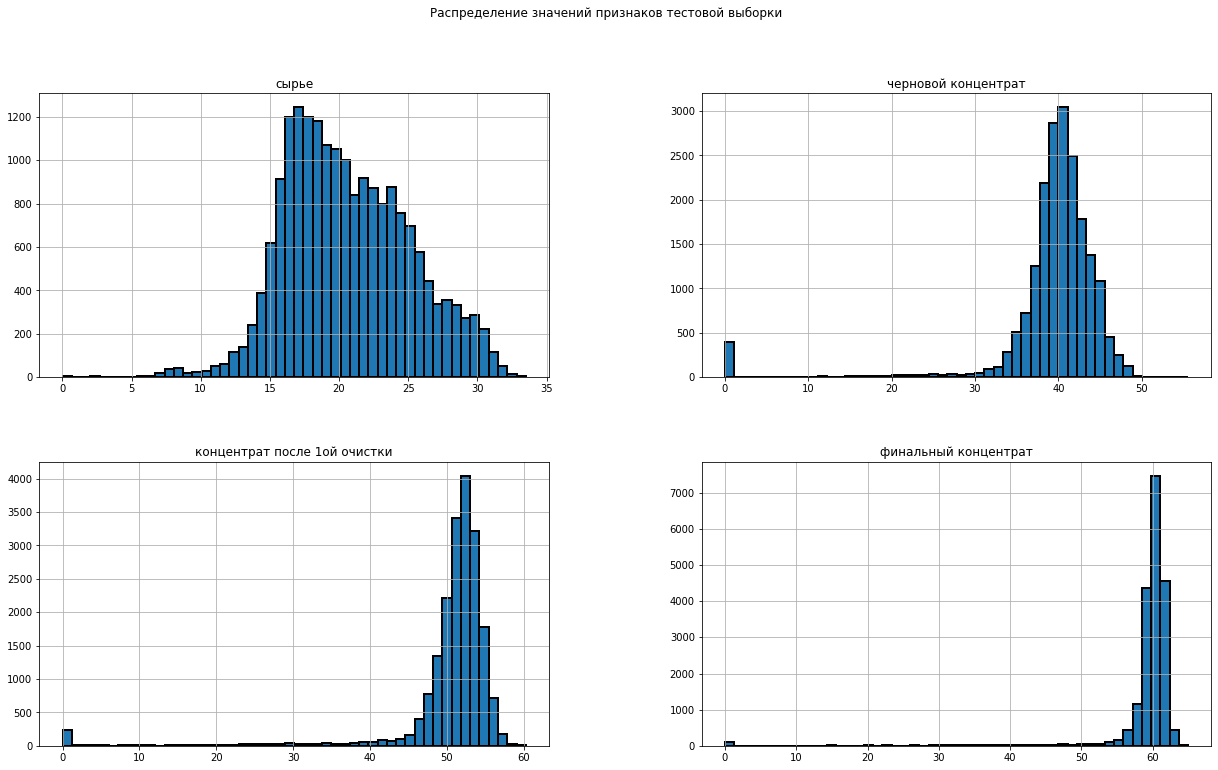

In [ ]:
fig, ax = plt.subplots(figsize=(21,12))
df_temp.hist(    bins=50,  edgecolor="black", linewidth=2, ax=ax)
plt.suptitle("Распределение значений признаков тестовой выборки")
plt.show()


**Вывод**

Проанализировали концентрации металлов на различных стадиях производства:

    золото:
    повышается по мере очистки и достигиает своих максимальных значений в конце технологического процесса
    серебро:
    повышается по завершению этапа флотации и по мере очистики начианет снижаться
    свинец:
    содержание свинца начинает подниматься по завершению эатапа флотации и сохраняется либо незначительно увеличивается на этапах очистки

Проверили распределяни значений размеров гранул как на этапе подготовки сырья, так и на этапе очистки - распредления схожи, дисперсии не различаются, нет необходимости в корректировке

In [ ]:
d1 = df_train.copy()
d2 = df_test.copy()
d3 = df_full.copy()

## Модель

### Подготовка функции для рассчета метрик



Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных.

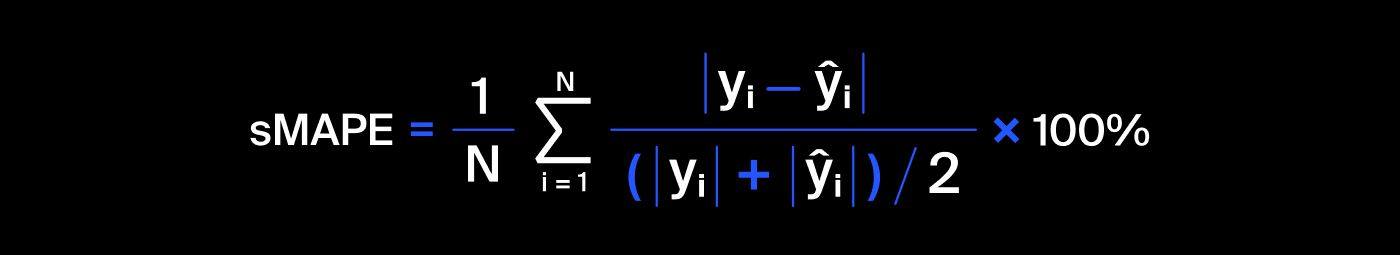

In [ ]:
def smape(y_true, y_pred):
    y_true_s = np.array(y_true) +1e-30
    y_pred_s = np.array(y_pred) +1e-30
    y_true_s = y_true_s.reshape(-1,1) 
    y_pred_s = y_pred_s.reshape(-1,1)       # делаю решейп, так как какие-то модели могут выдавать не тот формат данных, что нужно
    smape = sum(abs(y_true_s - y_pred_s) / ((abs(y_true_s) + abs(y_pred_s))/2) )*100 / len(y_true_s)
    return abs(smape)[0]

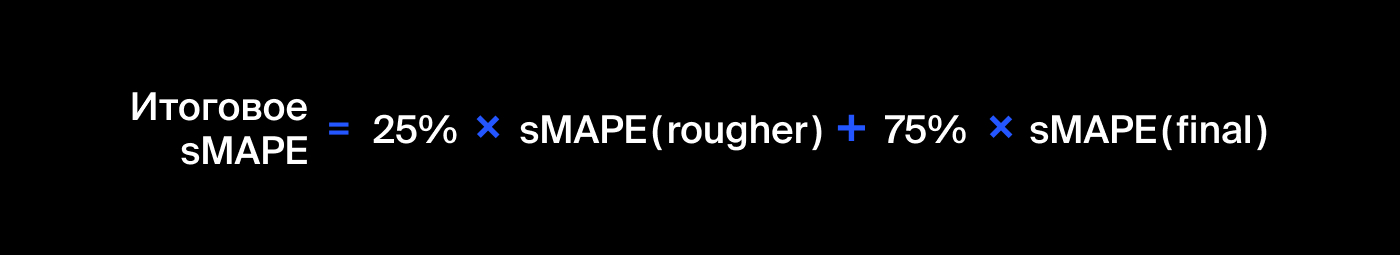

In [ ]:
def smape_final(smape1, smape2):
    smape_final = (0.25 * smape1 + 0.75 * smape2)
    return smape_final

### Подготовка данных

Объявим переменные:

In [ ]:
folds = 5  # количество выборок при к-в
rstate = 12345 # фиксируем значение псевдослучайности 
# n_trials=150
algorithms = [
    LinearRegression(),  
    CatBoostRegressor(loss_function = 'MAPE', silent=True, random_state=rstate), 
    LGBMRegressor(random_state=rstate), 
    XGBRegressor(random_state=rstate, booster='gbtree', objective='reg:squarederror'), 
    Lasso(alpha=0.1), 
    ElasticNet(random_state=rstate),
     ]  # применяемые модели

Создадим пару новых признаков, которых поместим в тренировочную и тестовую выборку.
Это будет информация о значениях целевых признаков за предыдущий момент времени. По сути мы, не делаем утечку, а просто даем моделям обратную связь. 
Исходим из того, что в продакшне информация по прошлым итерациям нам будет доступна.

In [ ]:
df_full['rougher.output.recovery_last'] = df_full['rougher.output.recovery'].shift(1)
df_full['final.output.recovery_last'] = df_full['final.output.recovery'].shift(1)
df_train['rougher.output.recovery_last'] = df_full.loc[df_train.index,'rougher.output.recovery_last']
df_train['final.output.recovery_last'] = df_full.loc[df_train.index,'final.output.recovery_last']
df_test['rougher.output.recovery_last'] = df_full.loc[df_test.index,'rougher.output.recovery_last']
df_test['final.output.recovery_last'] = df_full.loc[df_test.index,'final.output.recovery_last']

###  Заполнение пропусков 

Заполним пропуски в наших выборках средними на основе соседних значений:

In [ ]:
df_test = df_test.ffill(axis = 0).add(df_test.bfill(axis = 0)).div(2)
df_train = df_train.ffill(axis = 0).add(df_train.bfill(axis = 0)).div(2)

# добиваем те пропуски которые находятся в начале и в конце таблицы
df_train = df_train.ffill(axis = 0) 
df_train = df_train.bfill(axis = 0)

### Формируем выборки

Создадим выборки для предсказания `rougher.output.recovery`:

In [ ]:
y_test_r = df_full.loc[df_test.index,'rougher.output.recovery'].dropna().copy()
y_train_r = df_train['rougher.output.recovery'].dropna().copy()

X_train_r = df_train[df_test.columns[df_test.columns.str.contains('rougher')]].copy()  # формируем тренировочную выборку только из переченя столбцов тестовой выборки, связанных с флотацией  
X_train_r = X_train_r.loc[y_train_r.index] #  оставляем только индексы которые есть в таргете

X_test_r = df_test.copy()  # формируем тестовую выборку из переченя столбцов, связанных с флотацией 

X_test_r =  X_test_r.loc[y_test_r.index, X_train_r.columns].copy() # восстанавливаем порядок столбцов как в обучающей выборке


Создадим выборки для предсказания `final.output.recovery`:

In [ ]:
y_train_f = df_train['final.output.recovery'].dropna().copy()
y_test_f = df_full.loc[df_test.index,'final.output.recovery'].dropna().copy()
X_train_f = df_train.loc[y_train_f.index, df_test.columns].copy() #  оставляем только индексы которые есть в таргете и колонки с тестовой
X_test_f = df_test.loc[y_test_f.index].copy() #  оставляем только индексы которые есть в таргете
X_test_f =  X_test_f[X_train_f.columns] # восстанавливаем порядок столбцов как в обучающей выборке


Добавим целенаправленную утечку целевых признаков в наши признаки. Сoздадим столбец, который будет показывать, что в эти даты счетчик, [согласно нашим предположениям](#malf), был неисправен:

In [ ]:
df_full['malf1'] = (df_full['rougher.output.recovery']<=0.01 )*1
df_full['malf2'] = (df_full['rougher.output.recovery']==100 )*1
df_full['malf3'] = (df_full['final.output.recovery']<=0.01 )*1
df_full['malf4'] = (df_full['final.output.recovery']==100 )*1

cols = ['malf1','malf2']
X_train_r[cols] = df_full.loc[X_train_r.index, cols ]
X_test_r[cols] = df_full.loc[X_test_r.index, cols ]
cols = ['malf3','malf4']
X_train_f[cols] = df_full.loc[X_train_f.index, cols ]
X_test_f[cols] = df_full.loc[X_test_f.index, cols ]

In [ ]:
print(X_train_r.shape)
X_train_r.columns

(14149, 25)


Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level', 'rougher.output.recovery_last',
       'malf1', 'malf2'],
      dtype='object')

In [ ]:
print(X_test_f.shape)
X_test_f.columns

(5290, 56)


Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

Мы разделили наши выборки на две составляющих - для этапа флотации и этапа очистки: `X_train_r`,`y_train_r`, `X_test_r`, `y_test_r`,   
`X_train_f`,`y_train_f`, `X_test_f`, `y_test_f`и добавили новых признаков для обучения моделей.

Уменьшим битность данных, для ускорения работы с таблицами:

In [ ]:
for i in X_train_r.select_dtypes(include=["float64"]).columns.tolist():
  X_train_r[i] = X_train_r[i].astype(np.float32)
  X_test_r[i] = X_test_r[i].astype(np.float32)

for i in X_train_f.select_dtypes(include=["float64"]).columns.tolist():
  X_train_f[i] = X_train_f[i].astype(np.float32)
  X_test_f[i] = X_test_f[i].astype(np.float32)

In [ ]:
X_train_r.dtypes

rougher.input.feed_ag                 float32
rougher.input.feed_pb                 float32
rougher.input.feed_rate               float32
rougher.input.feed_size               float32
rougher.input.feed_sol                float32
rougher.input.feed_au                 float32
rougher.input.floatbank10_sulfate     float32
rougher.input.floatbank10_xanthate    float32
rougher.input.floatbank11_sulfate     float32
rougher.input.floatbank11_xanthate    float32
rougher.state.floatbank10_a_air       float32
rougher.state.floatbank10_a_level     float32
rougher.state.floatbank10_b_air       float32
rougher.state.floatbank10_b_level     float32
rougher.state.floatbank10_c_air       float32
rougher.state.floatbank10_c_level     float32
rougher.state.floatbank10_d_air       float32
rougher.state.floatbank10_d_level     float32
rougher.state.floatbank10_e_air       float32
rougher.state.floatbank10_e_level     float32
rougher.state.floatbank10_f_air       float32
rougher.state.floatbank10_f_level 

### Обучение

Создадим функцию, которая сохранит результаты моделей:

In [ ]:
def lets_predict(X_train, y_train):
  best_result = 9999
  best_model = None
  df_report = pd.DataFrame()  # создаем таблицу для заноса метрик
  metric_vals = pd.DataFrame()  # создаем таблицу для заноса всех значений основной метрики

  for n in range(len(algorithms)):  
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=rstate)
    cv_preds = []
    r2 =[]
    rmse = []
    mae = []
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)): # блок кроссвалидации
      X_trainCV, X_testCV = X_train.iloc[train_idx], X_train.iloc[test_idx]
      y_trainCV, y_testCV = y_train.iloc[train_idx], y_train.iloc[test_idx]
      model = deepcopy(algorithms[n])
      model.fit(X_trainCV, y_trainCV)
      preds = model.predict(X_testCV)
      cv_preds.append(smape(y_testCV, preds))
      r2.append(r2_score(y_testCV, preds))
      mae.append(mean_absolute_error(y_testCV, preds))
      rmse.append(mean_squared_error(y_testCV, preds, squared=False))
      metric_vals.loc[idx, model.__class__.__name__] = smape(y_testCV, preds)

    result = np.mean(cv_preds)
    #  заносим в таблицу метрики 
    df_report.loc[model.__class__.__name__,"mae"] = np.mean(mae)
    df_report.loc[model.__class__.__name__, "rmse"] = np.mean(rmse)
    df_report.loc[model.__class__.__name__, "r2"] = np.mean(r2)
    df_report.loc[model.__class__.__name__, "smape"] = result

    if result < best_result:
      best_result = result
      best_model = deepcopy(algorithms[n])

  print(best_result)
  return df_report, best_model, metric_vals

Создадим функцию константной модели, которая будет применять либо среднюю, либо медиану для предсказания таргета:

In [ ]:
def dummy():
  best_model_dummy = None
  best_result = 99999
  best_strat = ''
  strategies = ["mean", "median"]
  for strat in strategies:
    model = DummyRegressor( strategy=strat) 
    model.fit(X_train, y_train) 
    result = smape(y_test, model.predict(X_test)) # посчитаем качество модели
    if result < best_result:
      best_model_dummy = model
      best_result = result
      best_strat = strat
  print(best_strat)
  return best_result

Обучаемся для предсказания эффективности обогащения чернового концентрата:

In [ ]:
%%time
df_report_rougher,  model_rougher, metric_vals1 = lets_predict(X_train_r, y_train_r)

3.698307225655168
CPU times: user 1min 29s, sys: 3.63 s, total: 1min 32s
Wall time: 54.6 s


Выводим отчет:

In [ ]:
df_report_rougher

,mae,rmse,r2,smape
LinearRegression,3.26,5.10,0.87,8.06
CatBoostRegressor,2.70,4.49,0.90,3.70
LGBMRegressor,1.74,3.28,0.95,6.43
XGBRegressor,1.83,3.49,0.94,6.51
Lasso,3.05,5.25,0.87,7.82
ElasticNet,2.87,7.99,0.69,7.29


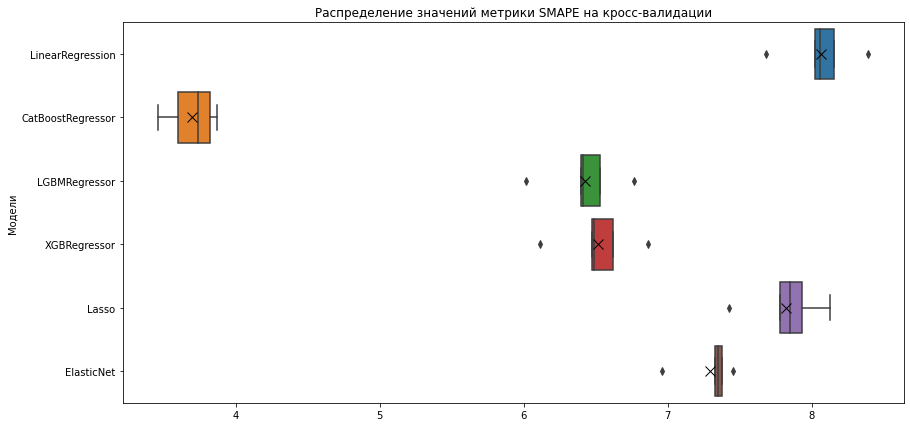

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
sns.boxplot(data=metric_vals1, orient='h', 
                    showmeans=True, 
                    meanprops={'marker': 'x',
                               'markeredgecolor': 'black',
                               'markersize': '10'})
                               
                               
plt.title('Распределение значений метрики SMAPE на кросс-валидации')                              
plt.ylabel('Модели')                              
plt.show()

Теперь проверим лучшую модель на тестовых данных:

In [ ]:
X_train = X_train_r.copy()
y_train = y_train_r.copy()
X_test = X_test_r.copy()
y_test = y_test_r.copy()

In [ ]:
model_rougher.fit(X_train, y_train)
smape1 = smape(y_test, model_rougher.predict(X_test))
smape1

3.7314169241890554

In [ ]:
dummy()

median


8.627729267935692

Лучшая обученная показывает результат лучше константной модели. Можно брать в работу.

Посмотрим важность признаков для модели:

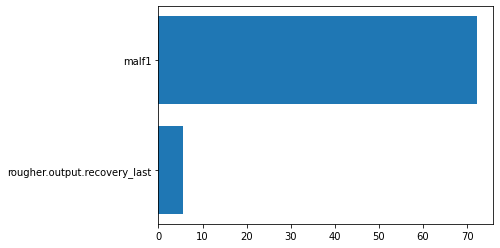

In [ ]:
try:
  t = pd.DataFrame(model_rougher.feature_importances_, index = X_train.columns)
  t = t[t>t.mean()].dropna().sort_values(by=0)
  plt.barh(t.index, t[0])
  plt.show()
except:
  print("ошибка")

Обучаемся для предсказания эффективности обогащения финального концентрата:

In [ ]:
%%time
df_report_final,  model_final, metric_vals2 = lets_predict(X_train_f, y_train_f)

5.7014685640985565
CPU times: user 3min 7s, sys: 4.01 s, total: 3min 11s
Wall time: 1min 55s


Выводим отчет:

In [ ]:
df_report_final

,mae,rmse,r2,smape
LinearRegression,3.56,5.80,0.68,6.53
CatBoostRegressor,3.65,5.87,0.67,6.68
LGBMRegressor,3.00,5.19,0.74,5.70
XGBRegressor,3.05,5.22,0.74,5.81
Lasso,3.54,6.24,0.63,6.44
ElasticNet,3.63,6.74,0.57,6.48


Теперь проверим лучшую модель на тестовых данных:

In [ ]:
X_train = X_train_f.copy()
y_train = y_train_f.copy()
X_test = X_test_f.copy()
y_test = y_test_f.copy()

In [ ]:
model_final.fit(X_train, y_train)
smape2 = smape(y_test, model_final.predict(X_test))
smape2

6.323810944760154

In [ ]:
dummy()

median


9.763982508185252

Лучшая обученная модель показывает результат лучше константной модели.

Посмотрим важность признаков для модели:

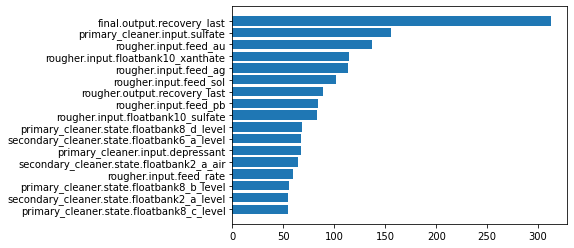

In [ ]:
try:
  t = pd.DataFrame(model_final.feature_importances_, index = X_train.columns)
  t = t[t>t.mean()].dropna().sort_values(by=0)
  plt.barh(t.index, t[0])
  plt.show()
except:
  print("ошибка")

Посчитаем итоговую метрику:

In [ ]:
smape_final(smape1 ,smape2)

5.675712439617379

### Анализ результатов модели

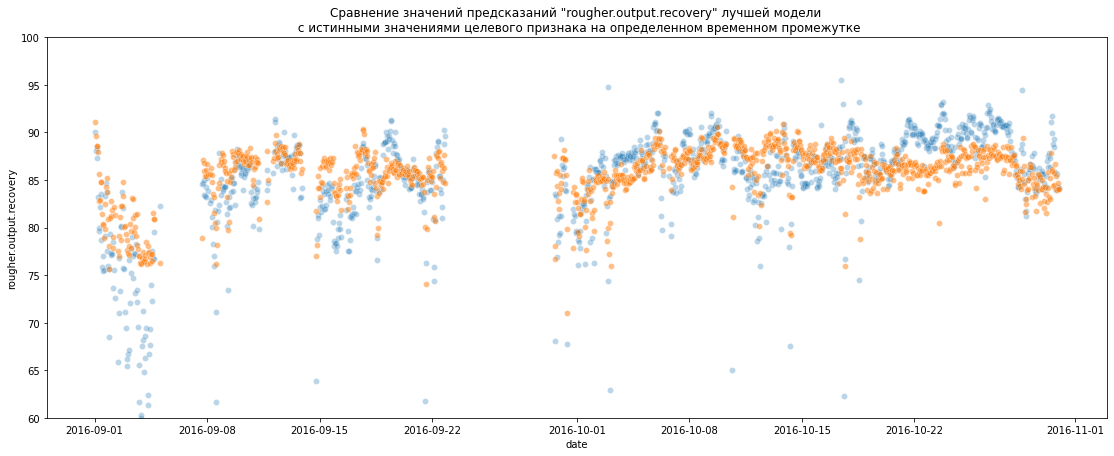

In [ ]:
df_temp = pd.DataFrame(index = y_test_r.index)
df_temp['y_true'] = y_test_r
df_temp['y_pred'] = model_rougher.predict(X_test_r)
df_temp['diff'] = abs(df_temp['y_true']-df_temp['y_pred'])
df_temp = df_temp.join(X_test_r)
df_temp['day_date'] =df_temp.index.to_numpy().astype('datetime64[D]')
df_temp2 = df_full_raw.copy()
df_temp2["date"] = pd.to_datetime(df_temp2["date"], format="%Y-%m-%d %H:%M:%S") 
df_temp2 = df_temp2.sort_values('date').set_index('date')
df_temp = df_temp.join(df_temp2['rougher.output.recovery'])  
df_temp = df_temp.join(df_temp2['final.output.recovery'])  
fig, ax = plt.subplots(figsize=(19,7))
sns.scatterplot(
    x="date",
    y="rougher.output.recovery", data = df_temp[(df_temp['day_date']>'2016-01-01')& (df_temp['day_date']<'2016-10-31')].sort_values(by='date'), alpha=0.3)
sns.scatterplot(
    x="date",
    y="y_pred", data = df_temp[(df_temp['day_date']>'2016-01-01')& (df_temp['day_date']<'2016-10-31')].sort_values(by='date'), alpha=0.5)
plt.ylim(60,100)
plt.title('Сравнение значений предсказаний лучшей модели с истинными значениями \n целевого признака "rougher.output.recovery" на определенном временном промежутке')
plt.show()

Сравним визуально предсказанные и истинные значения по первому целевому признаку:

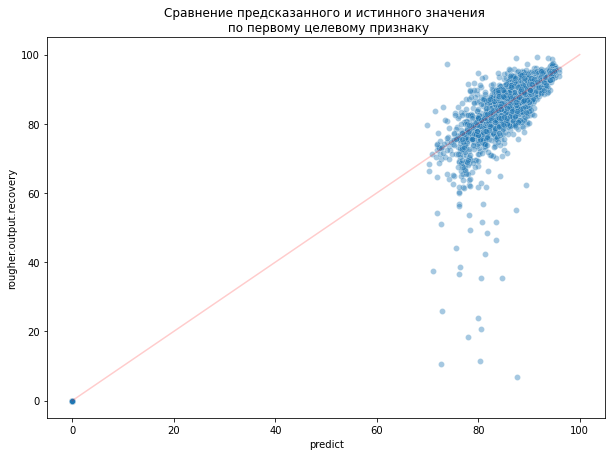

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(
    x=model_rougher.predict(X_test_r),
    y=y_test_r, alpha=0.4)
plt.xlabel("predict")
x = np.linspace(0, 100,100)
y = lambda x: x
plt.plot(x, y(x),  alpha=0.2, color='r')
plt.title('Сравнение предсказанного и истинного значения \n по первому целевому признаку')
plt.show()

Сравним визуально предсказанные и истинные значения по второму целевому признаку:

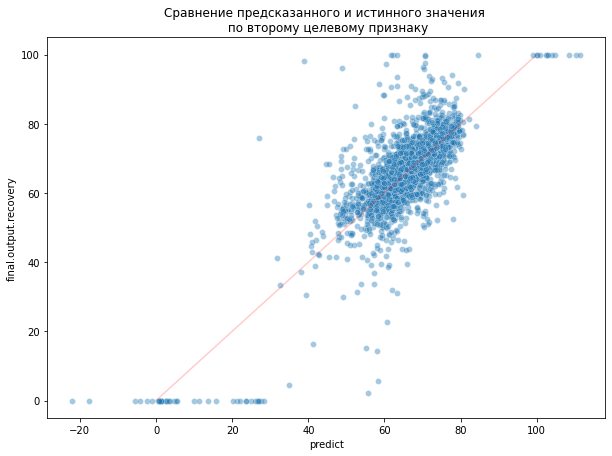

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(
    x=model_final.predict(X_test_f),
    y=y_test_f, alpha=0.4)
plt.xlabel("predict")
x = np.linspace(0, 100,100)
y = lambda x: x
plt.plot(x, y(x),  alpha=0.2, color='r')
plt.title('Сравнение предсказанного и истинного значения \n по второму целевому признаку')
plt.show()

Теперь посмотрим на каком диапазоне значений в предсказаниях признака `rougher.output.recovery` надо больше сосредоточиться, чтобы улучшить модель:

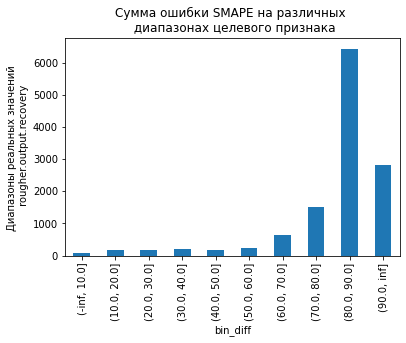

In [ ]:
df_temp = pd.DataFrame(index = y_test_r.index)
df_temp['y_true'] = y_test_r
df_temp['y_pred'] = model_rougher.predict(X_test_r)
df_temp['diff'] = abs(df_temp['y_true']-df_temp['y_pred'])
df_temp = df_temp.join(X_test_r)
df_temp['bin_diff'] = pd.cut(df_temp['y_true'],[-float('inf'),10,20,30,40,50,60,70,80,90,float('inf')]) 
df_temp.groupby('bin_diff')['diff'].sum().plot(kind='bar')
plt.ylabel('Сумма SMAPE по предсказаниям модели')
plt.ylabel('Диапазоны реальных значений \n rougher.output.recovery')
plt.title('Сумма ошибки SMAPE на различных \n диапазонах целевого признака')
plt.show()

Больший вес ошибок в конечной SMAPE по `rougher.output.recovery` приходиться на предсказания значений в районе 80-90.

## Стекинг

Попробуем улучшить наши предсказания признака `rougher.output.recovery` через мета-модель, которая будет принимать предсказания двух моделей:
нашей до этого обученной модели и facebook prophet, заточенной на предсказании на временных рядах.

In [ ]:
# создаем модель Prohet
model = fbp.Prophet().add_seasonality(name='monthly', period=30, fourier_order=12)   #daily_seasonality=True) seasonality_mode='multiplicative'
t = pd.DataFrame()
t['ds'] = df_full.index
t.index = df_full.index
t['y'] = df_full['rougher.output.recovery']

t = t.reset_index(drop=True)

train = t[t['ds']<='2017-01-15']
test = t[t['ds']>'2017-01-15']

model.fit(train)        # обучаем на данных до  2017-01-15
future = model.make_future_dataframe(periods=1)
forecast = model.predict(future)

forecast['yhat']

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprnz0scnd/toawhjoo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprnz0scnd/3_s2io2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58671', 'data', 'file=/tmp/tmprnz0scnd/toawhjoo.json', 'init=/tmp/tmprnz0scnd/3_s2io2p.json', 'output', 'file=/tmp/tmpslczy9j2/prophet_model-20220820133004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:30:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:30:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0      78.62
1      78.50
2      78.38
3      78.38
4      78.50
        ... 
7581   89.49
7582   89.57
7583   89.60
7584   89.54
7585   91.89
Name: yhat, Length: 7586, dtype: float64

In [ ]:
df_temp_train = df_full[X_train_r.columns]
df_temp_train = df_temp_train.reset_index(drop=True)
df_temp_y = df_full['rougher.output.recovery'].reset_index(drop=True)

Будем тестировать нашу систему на индексах с 7585 по 7635:

In [ ]:
t[t['ds']>='2017-01-15'].head()

,ds,y
7585,2017-01-18 13:59:59,85.34
7586,2017-01-18 14:59:59,80.89
7587,2017-01-18 15:59:59,83.49
7588,2017-01-18 16:59:59,86.09
7589,2017-01-18 20:59:59,83.85


На шаге i в оба оценщика поступает данные для обучения (X_train) с информацией до i индекса.
В финальный оценщик приходят предсказания от обоих оценщиков, и уже от его предсказания считается метрика smapes_w_b на истинном значении целевого признака на i строке.
И сравнивается с smapes_wo_b на предсказаниях только первого оценщика, без второго и финального.
Короче говоря, симулируем входящий поток данных в реальном времени.
Мета модель обучается каждый раз заново на предыдущих данных и делает прогноз на i строке.

In [ ]:
smapes_w_b = []
smapes_wo_b = []
preds_frst_est = []
preds_sec_est = []
p =0
count = 0
for i in range(len(t)):
  if i>=7585 and count<50: # проверим 50 итераций
    count+=1
    train = t.loc[0:i-1,:]
    model = fbp.Prophet().add_seasonality(name='monthly', period=30, fourier_order=12) 
    model.fit(train)
    future = model.make_future_dataframe(periods=1)   #  генерируем будущую дату для prophet
    future.loc[i,:'ds'] = t.loc[i,:'ds']              # заменяем значение будущей даты сгенерированной prophet на истинное
    # display(future)
    forecast = model.predict(future)
    first_est = LGBMRegressor(random_state=rstate) 
    first_est.fit(df_temp_train.loc[train.index], df_temp_y[train.index])
    test_df_for_frst_est = np.array(df_temp_train.loc[i,:]).reshape(1, -1)
    p = first_est.predict(test_df_for_frst_est)[0]
    preds_frst_est.append(p)
    preds_sec_est.append(forecast['yhat'].tail(1).values[0]) # заносим показания prohet
    data = {'col1': preds_frst_est, 'col2': preds_sec_est}
    df_train_for_est = pd.DataFrame(data=data)
    try:
      y_for_main_est = df_temp_y[i-len(preds_sec_est)+1:i+1]
      main_est = LGBMRegressor(random_state=rstate) 
      main_est.fit(df_train_for_est[0:-1],y_for_main_est[0:-1])    # обучаем мета-модель
      main_preds = main_est.predict(df_train_for_est.tail(1))
      s = smape(y_for_main_est.tail(1).values[0],main_preds[0])
      smapes_w_b.append(smape(y_for_main_est.tail(1).values[0],main_preds[0]))
      smapes_wo_b.append(smape(y_for_main_est.tail(1).values[0],p))
    except:
      pass

print()
print('Smape со стекингом', np.mean(smapes_w_b))
print('Smape без стекинга', np.mean(smapes_wo_b))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprnz0scnd/ogz9w9ca.json


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.39 µs


DEBUG:cmdstanpy:input tempfile: /tmp/tmprnz0scnd/_ugjuptm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64810', 'data', 'file=/tmp/tmprnz0scnd/ogz9w9ca.json', 'init=/tmp/tmprnz0scnd/_ugjuptm.json', 'output', 'file=/tmp/tmp3ih68oud/prophet_model-20220820133012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:30:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:30:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprnz0scnd/tqvqgcc7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprnz0scnd/tv7_szpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan arg


Smape с бустингом 3.521590620208087
Smape без бустинга 3.244324861178324


Заметно, что ранее обученная модель без стекинга дает лучшие показатели. Видимо, нужна былее тонкая настройка fb prophet, чтобы улучшить результаты со стекингом.

## Вывод

Нам было поручено подготовить прототип модели машинного обучения для «Цифры».
Модель должна была спрогнозировать две величины:

    эффективность обогащения чернового концентрата.
    эффективность обогащения финального концентрата.

В процессе анализа были обнаружены аномалии и выбросы значений, что вероятнее всего - ошибка. Благодаря замене и чистке этих значений в тренировочной выборке удалось получить хорошие результаты на сырых данных тестовой выборки.

Лучший результат по метрике sMAPE в обоих случаях предсказаний величин показала модель на основе алгоритма LGBMRegressor.